## Imports and Functions

In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [2]:
# Relevant functions
def gnumeric_func (data, columns):
  data[columns] = data[columns].apply(lambda x: pd.factorize(x)[0])
  return data

## Importing Data

In [3]:
# import training data
path = r"C:\Users\Andrew\Documents\Metis\Cross_Sell_Prediction\Raw-Data"
df_train = pd.read_csv(path + "\\train.csv")
df_train.head(3)

id Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1   Male   44                1         28.0                   0   
1   2   Male   76                1          3.0                   0   
2   3   Male   47                1         28.0                   0   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   

   Response  
0         1  
1         0  
2         1

In [4]:
# there are no null rows in the training data
null_data = df_train[df_train.isnull().any(axis=1)]
null_data

Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []

In [5]:
## there are no duplicate ids in the training data
bool_series = df_train.duplicated() 
df_train[bool_series] 

Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []

## EDA and Baselining

0    0.877437
1    0.122563
Name: Response, dtype: float64


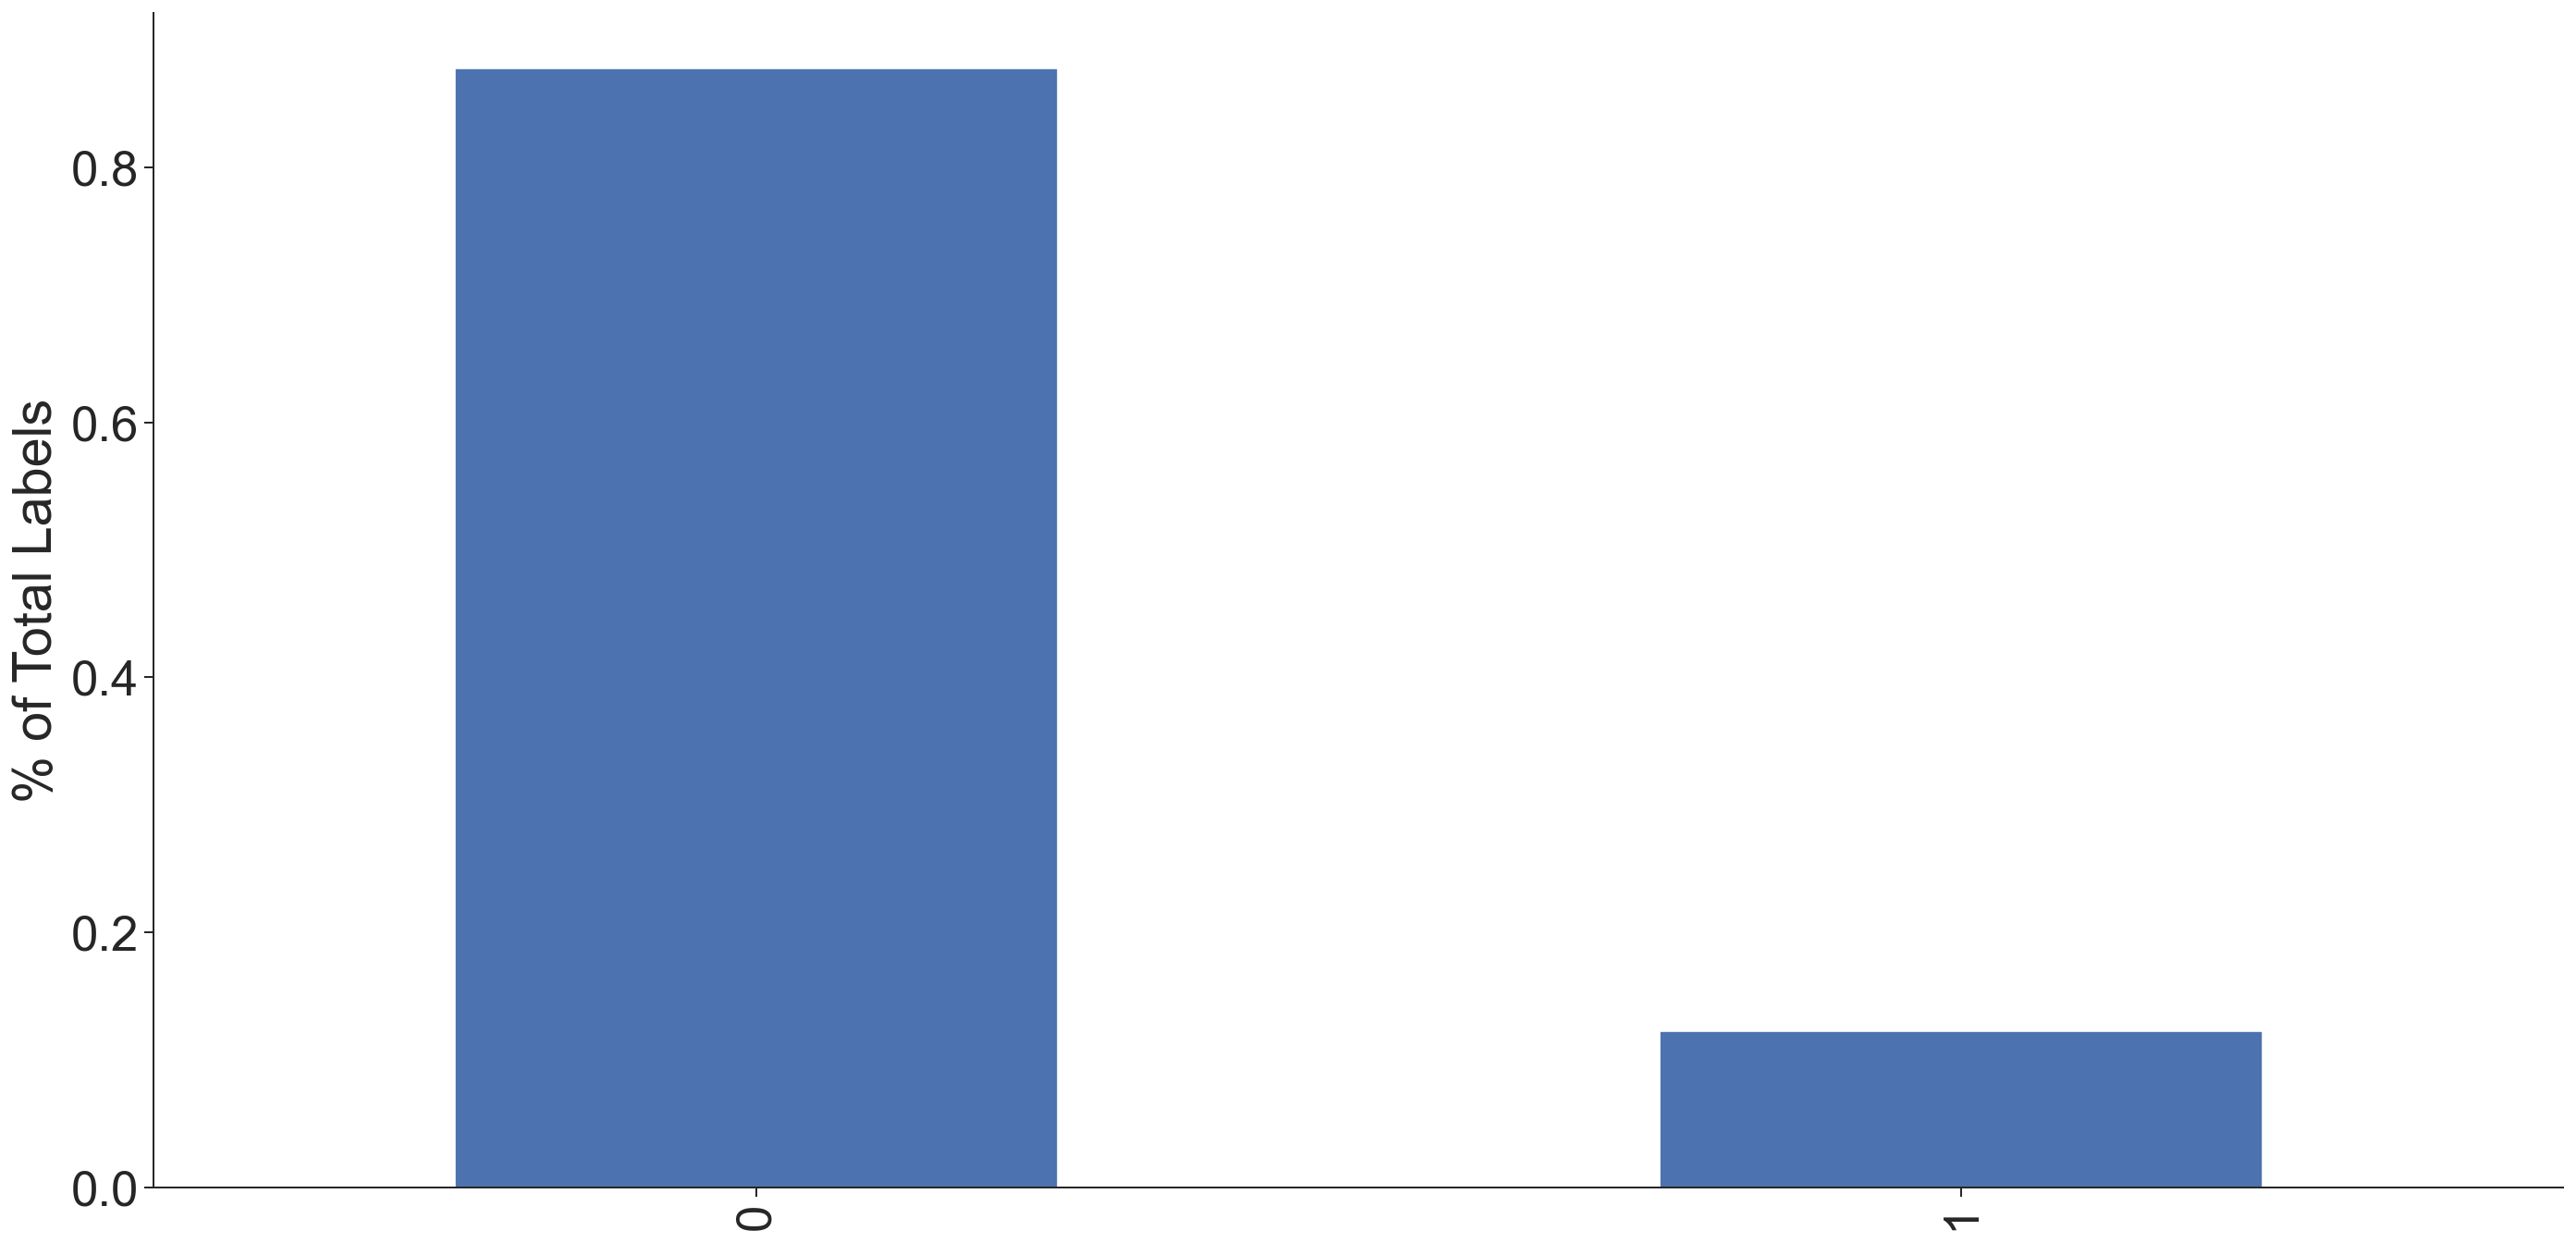

In [6]:
# check for distribution of the target
target_pcts = df_train.Response.value_counts(normalize=True) 
print(target_pcts)

f = plt.figure(figsize=(20,10))
sns.set_context('paper',font_scale = 3.0, rc = {"lines.linewidth": 1.0,'figure.figsize':(50,8.27)})
sns.set_style('white')


ax = target_pcts.plot(kind='bar')
ax.set(ylabel = "% of Total Labels")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('label_dist')

### Create variables to handle bimodal 

C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


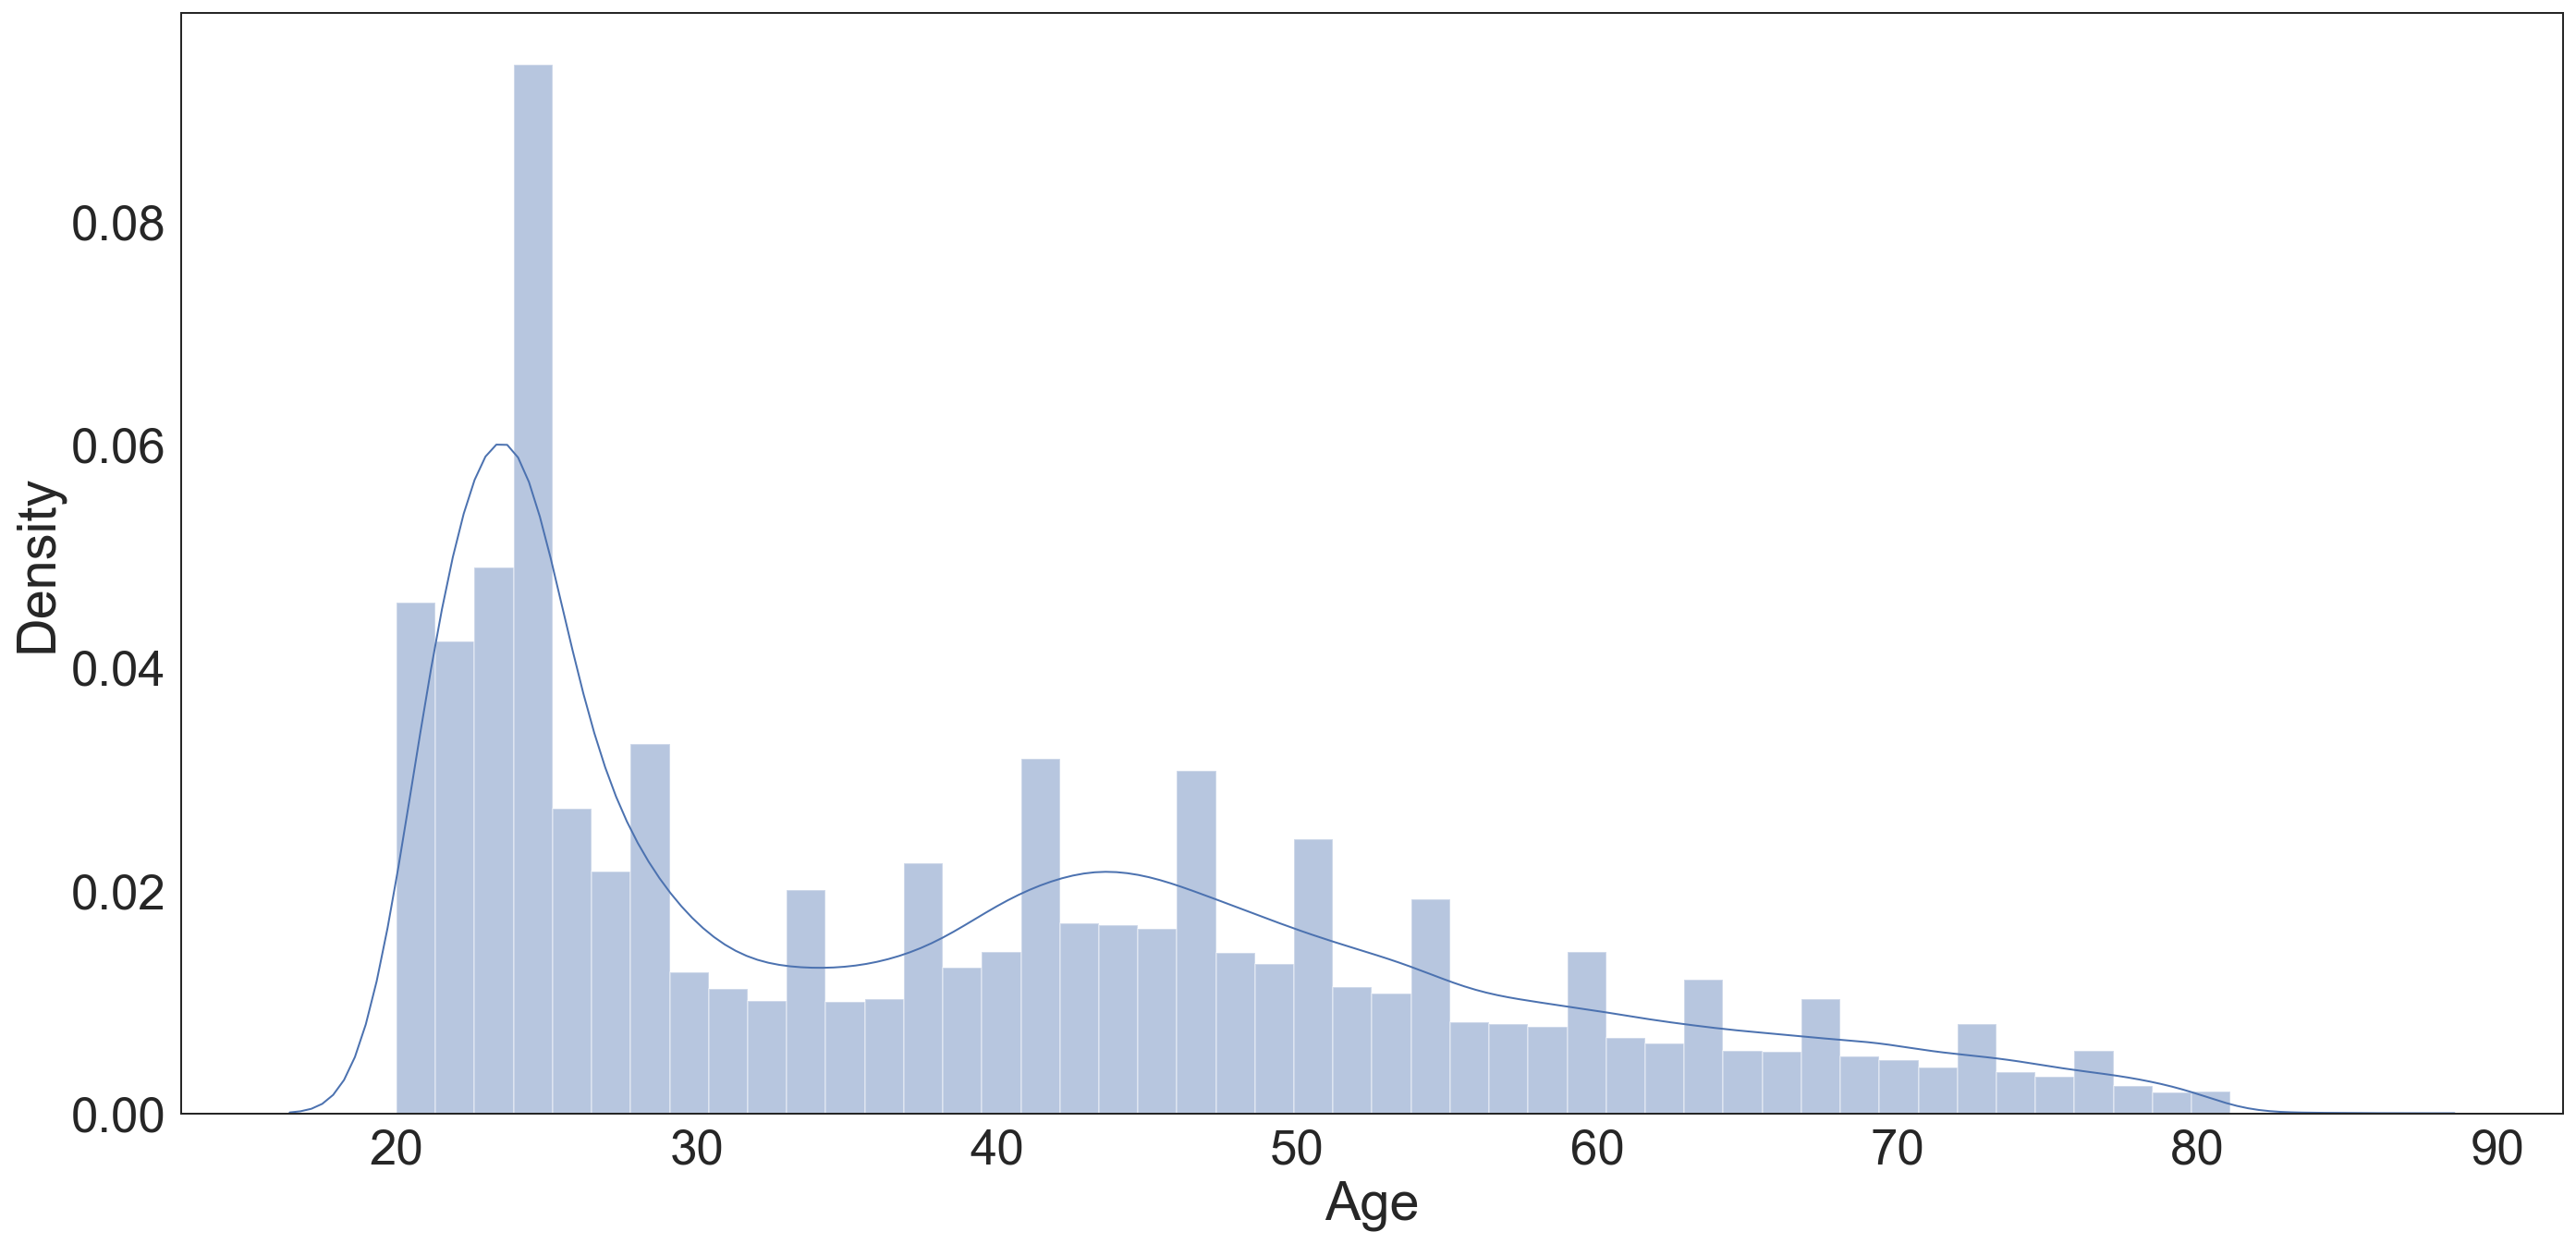

In [7]:
f = plt.figure(figsize=(20,10))
sns.set_context('paper',font_scale = 3.0, rc = {"lines.linewidth": 1.0,'figure.figsize':(50,8.27)})
sns.set_style('white')

ax = sns.distplot(df_train['Age'])

plt.tight_layout()
plt.savefig('age_dist')

In [8]:
# 1 if less than 33, else 0

df_train['young'] = pd.get_dummies(df_train['Age'] < 33,drop_first=True)
df_train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'young'],
      dtype='object')

C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


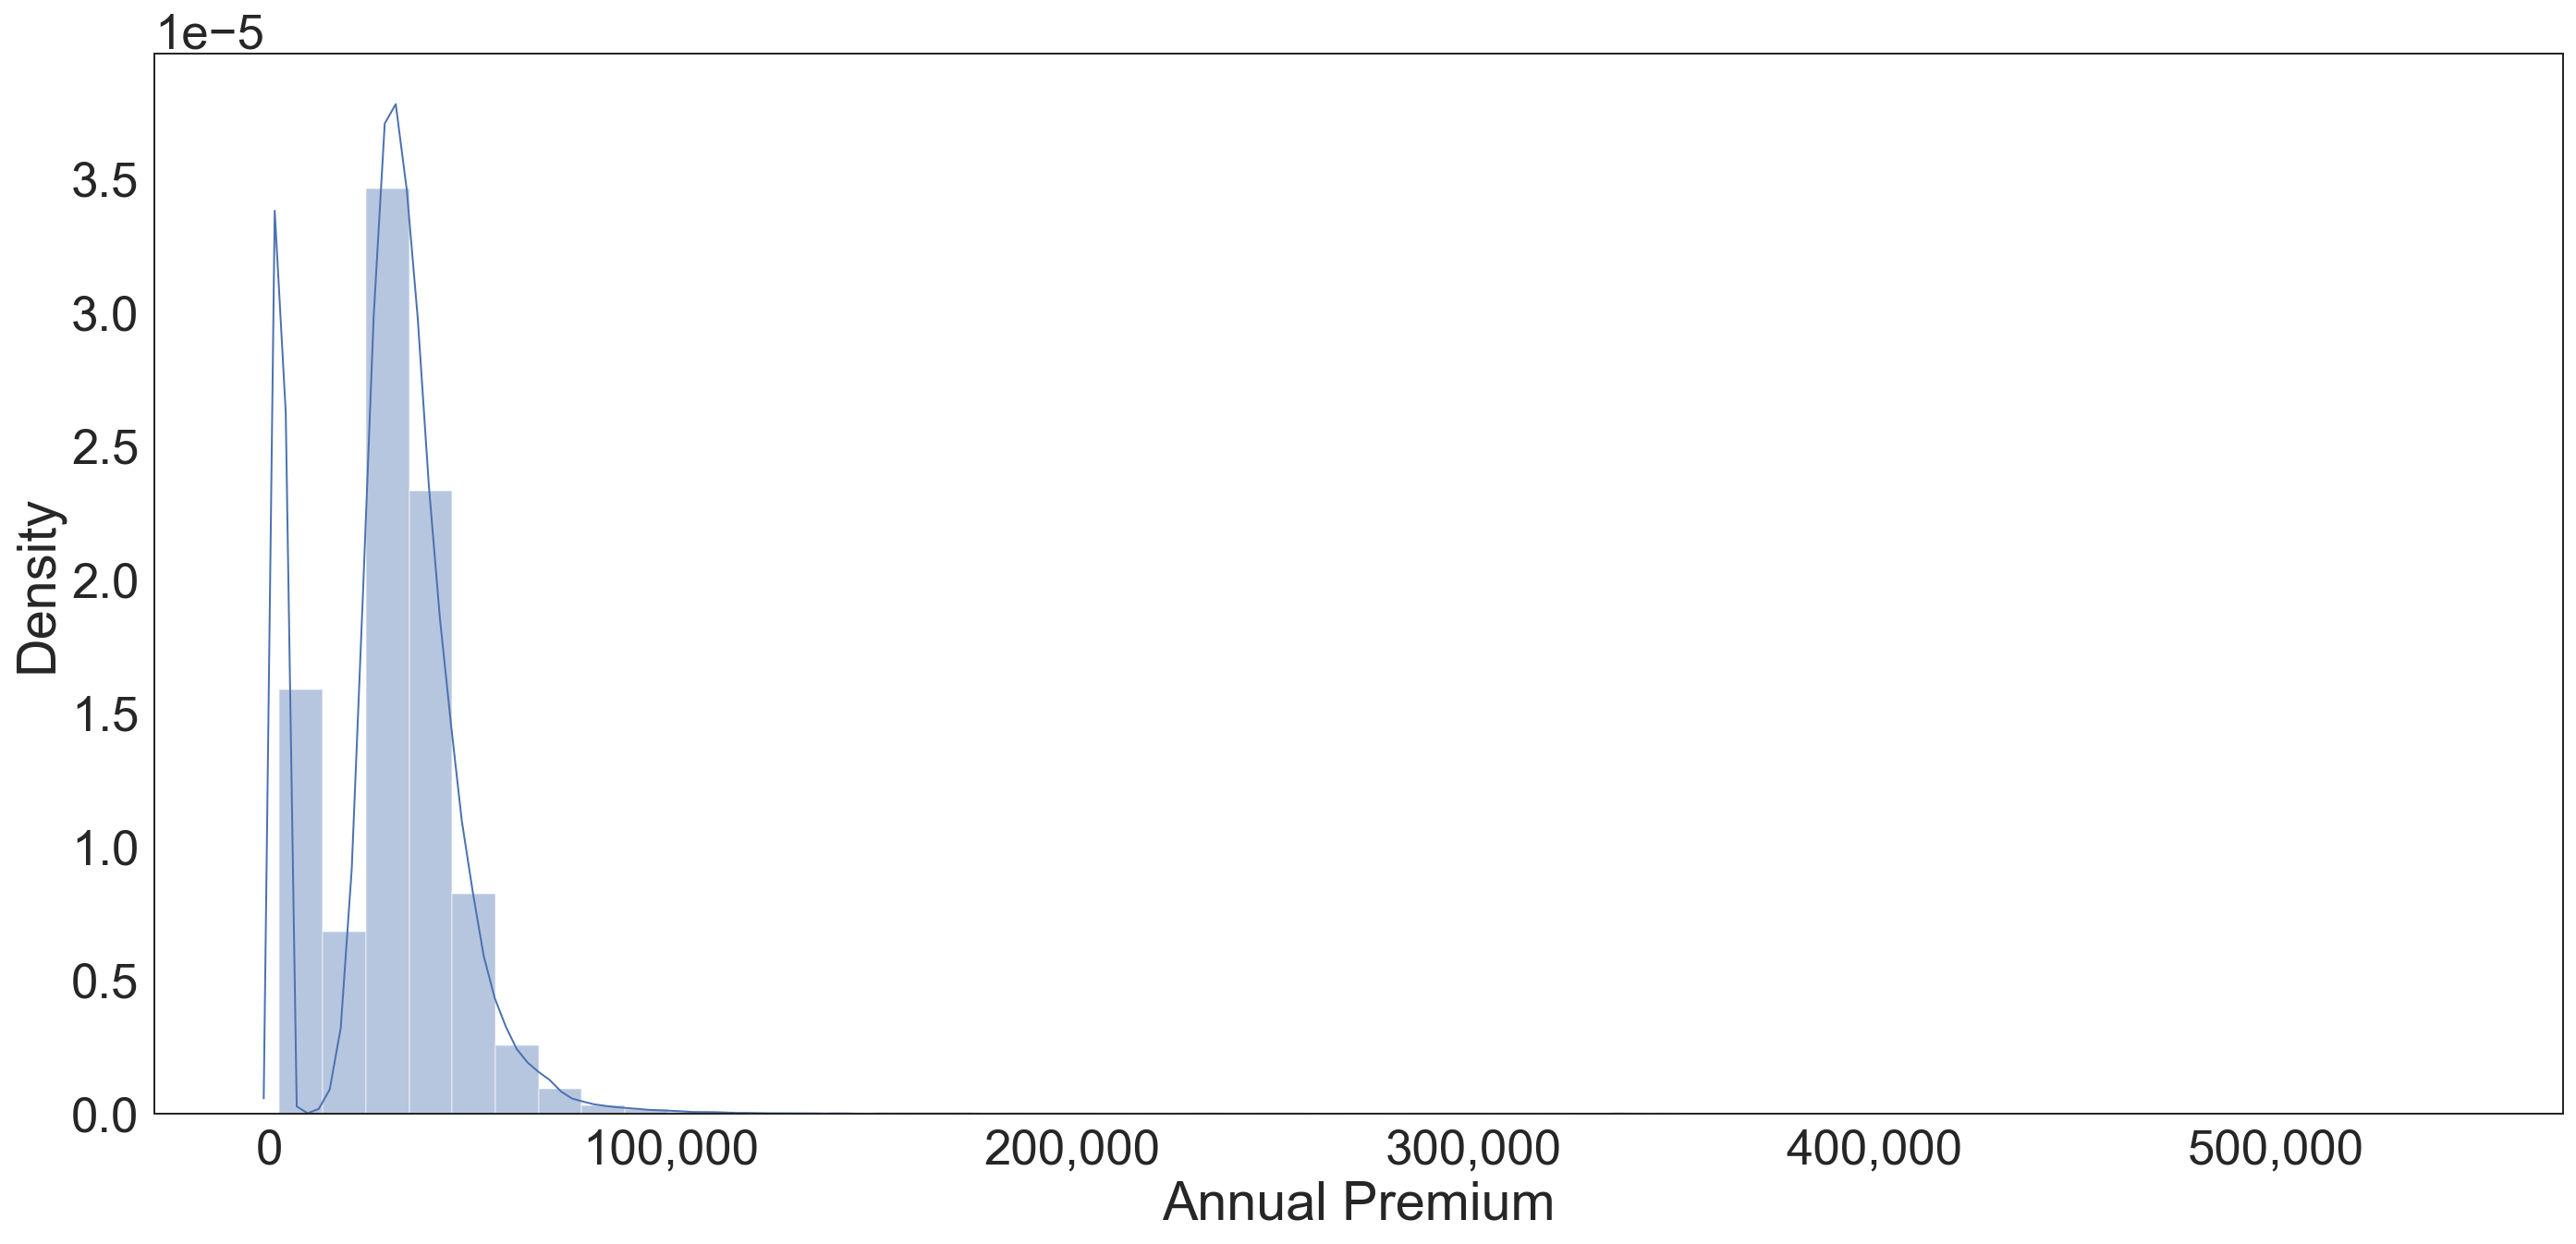

In [9]:
f = plt.figure(figsize=(20,10))
sns.set_context('paper',font_scale = 3.0, rc = {"lines.linewidth": 1.0,'figure.figsize':(50,8.27)})
sns.set_style('white')

ax = sns.distplot(df_train['Annual_Premium'])
ax.set(ylabel = "Density", xlabel = "Annual Premium")
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig('prem_dist')

In [10]:
df_train['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

In [11]:
# 1 if less than 10,000, else 0

df_train['Large_Premium'] = pd.get_dummies(df_train['Annual_Premium'] > 10000,drop_first=True)

C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


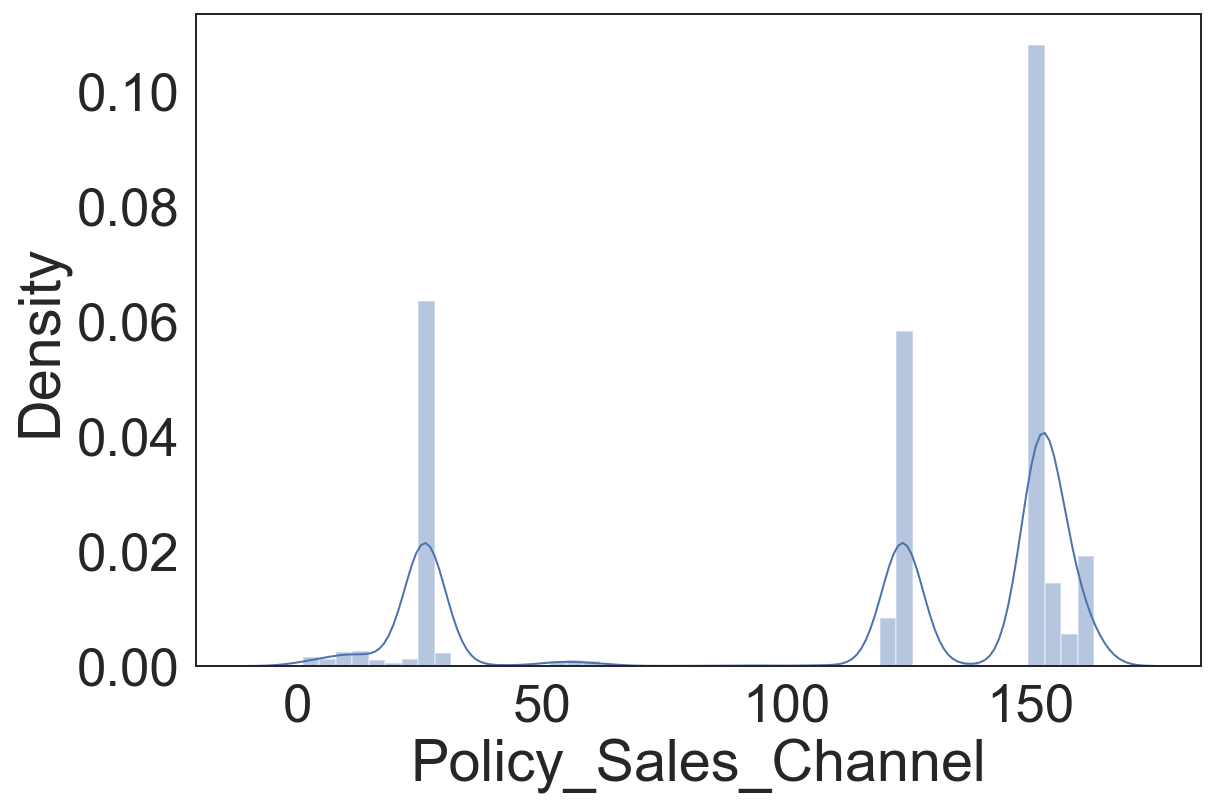

In [12]:
ax = sns.distplot(df_train['Policy_Sales_Channel'])

C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


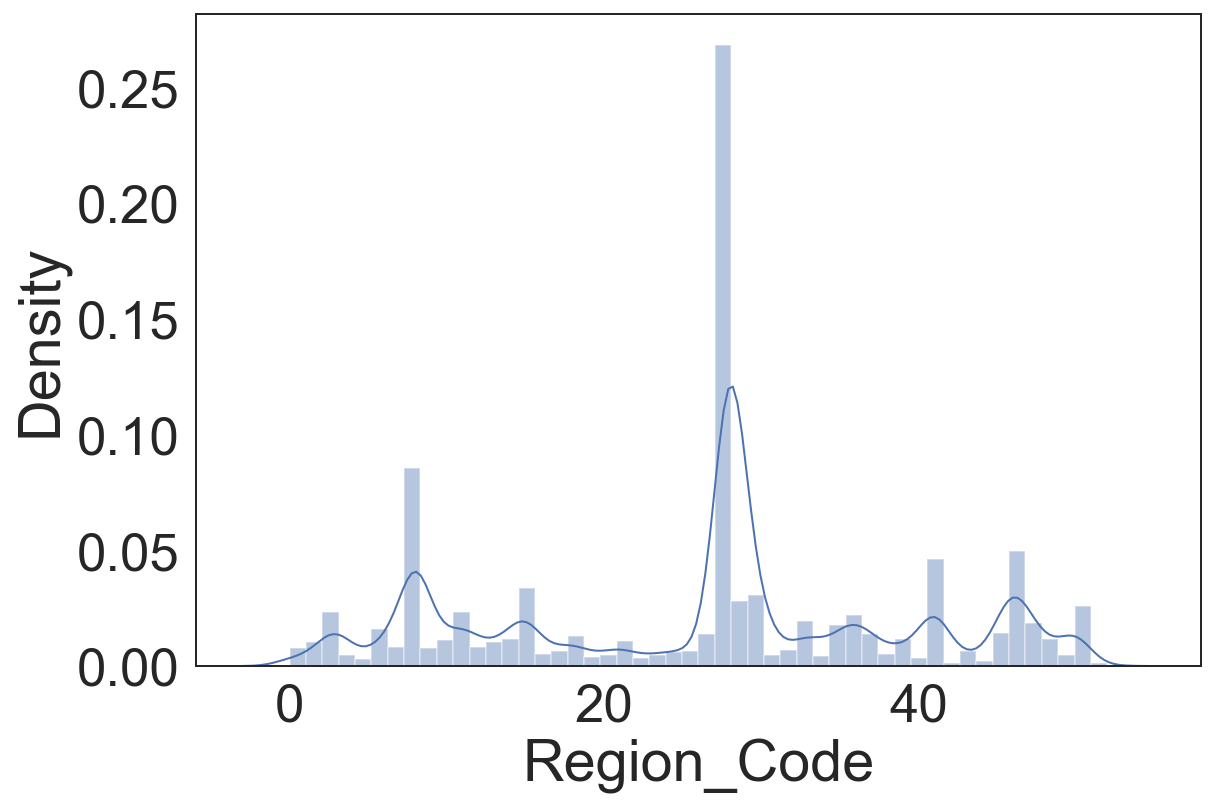

In [13]:
ax = sns.distplot(df_train['Region_Code'])

In [14]:
def plot_features(df, sample_size=1000):
    # We don't need to plot the id
    gnumeric_func(df, ['Gender']) 
    sample = df.drop(['id','young','Large_Premium'], axis=1) \
                .sample(sample_size, random_state=44)

    g = sns.pairplot(sample, hue='Response', plot_kws=dict(alpha=.3, edgecolor='none'))

C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Andrew\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1440x720 with 0 Axes>

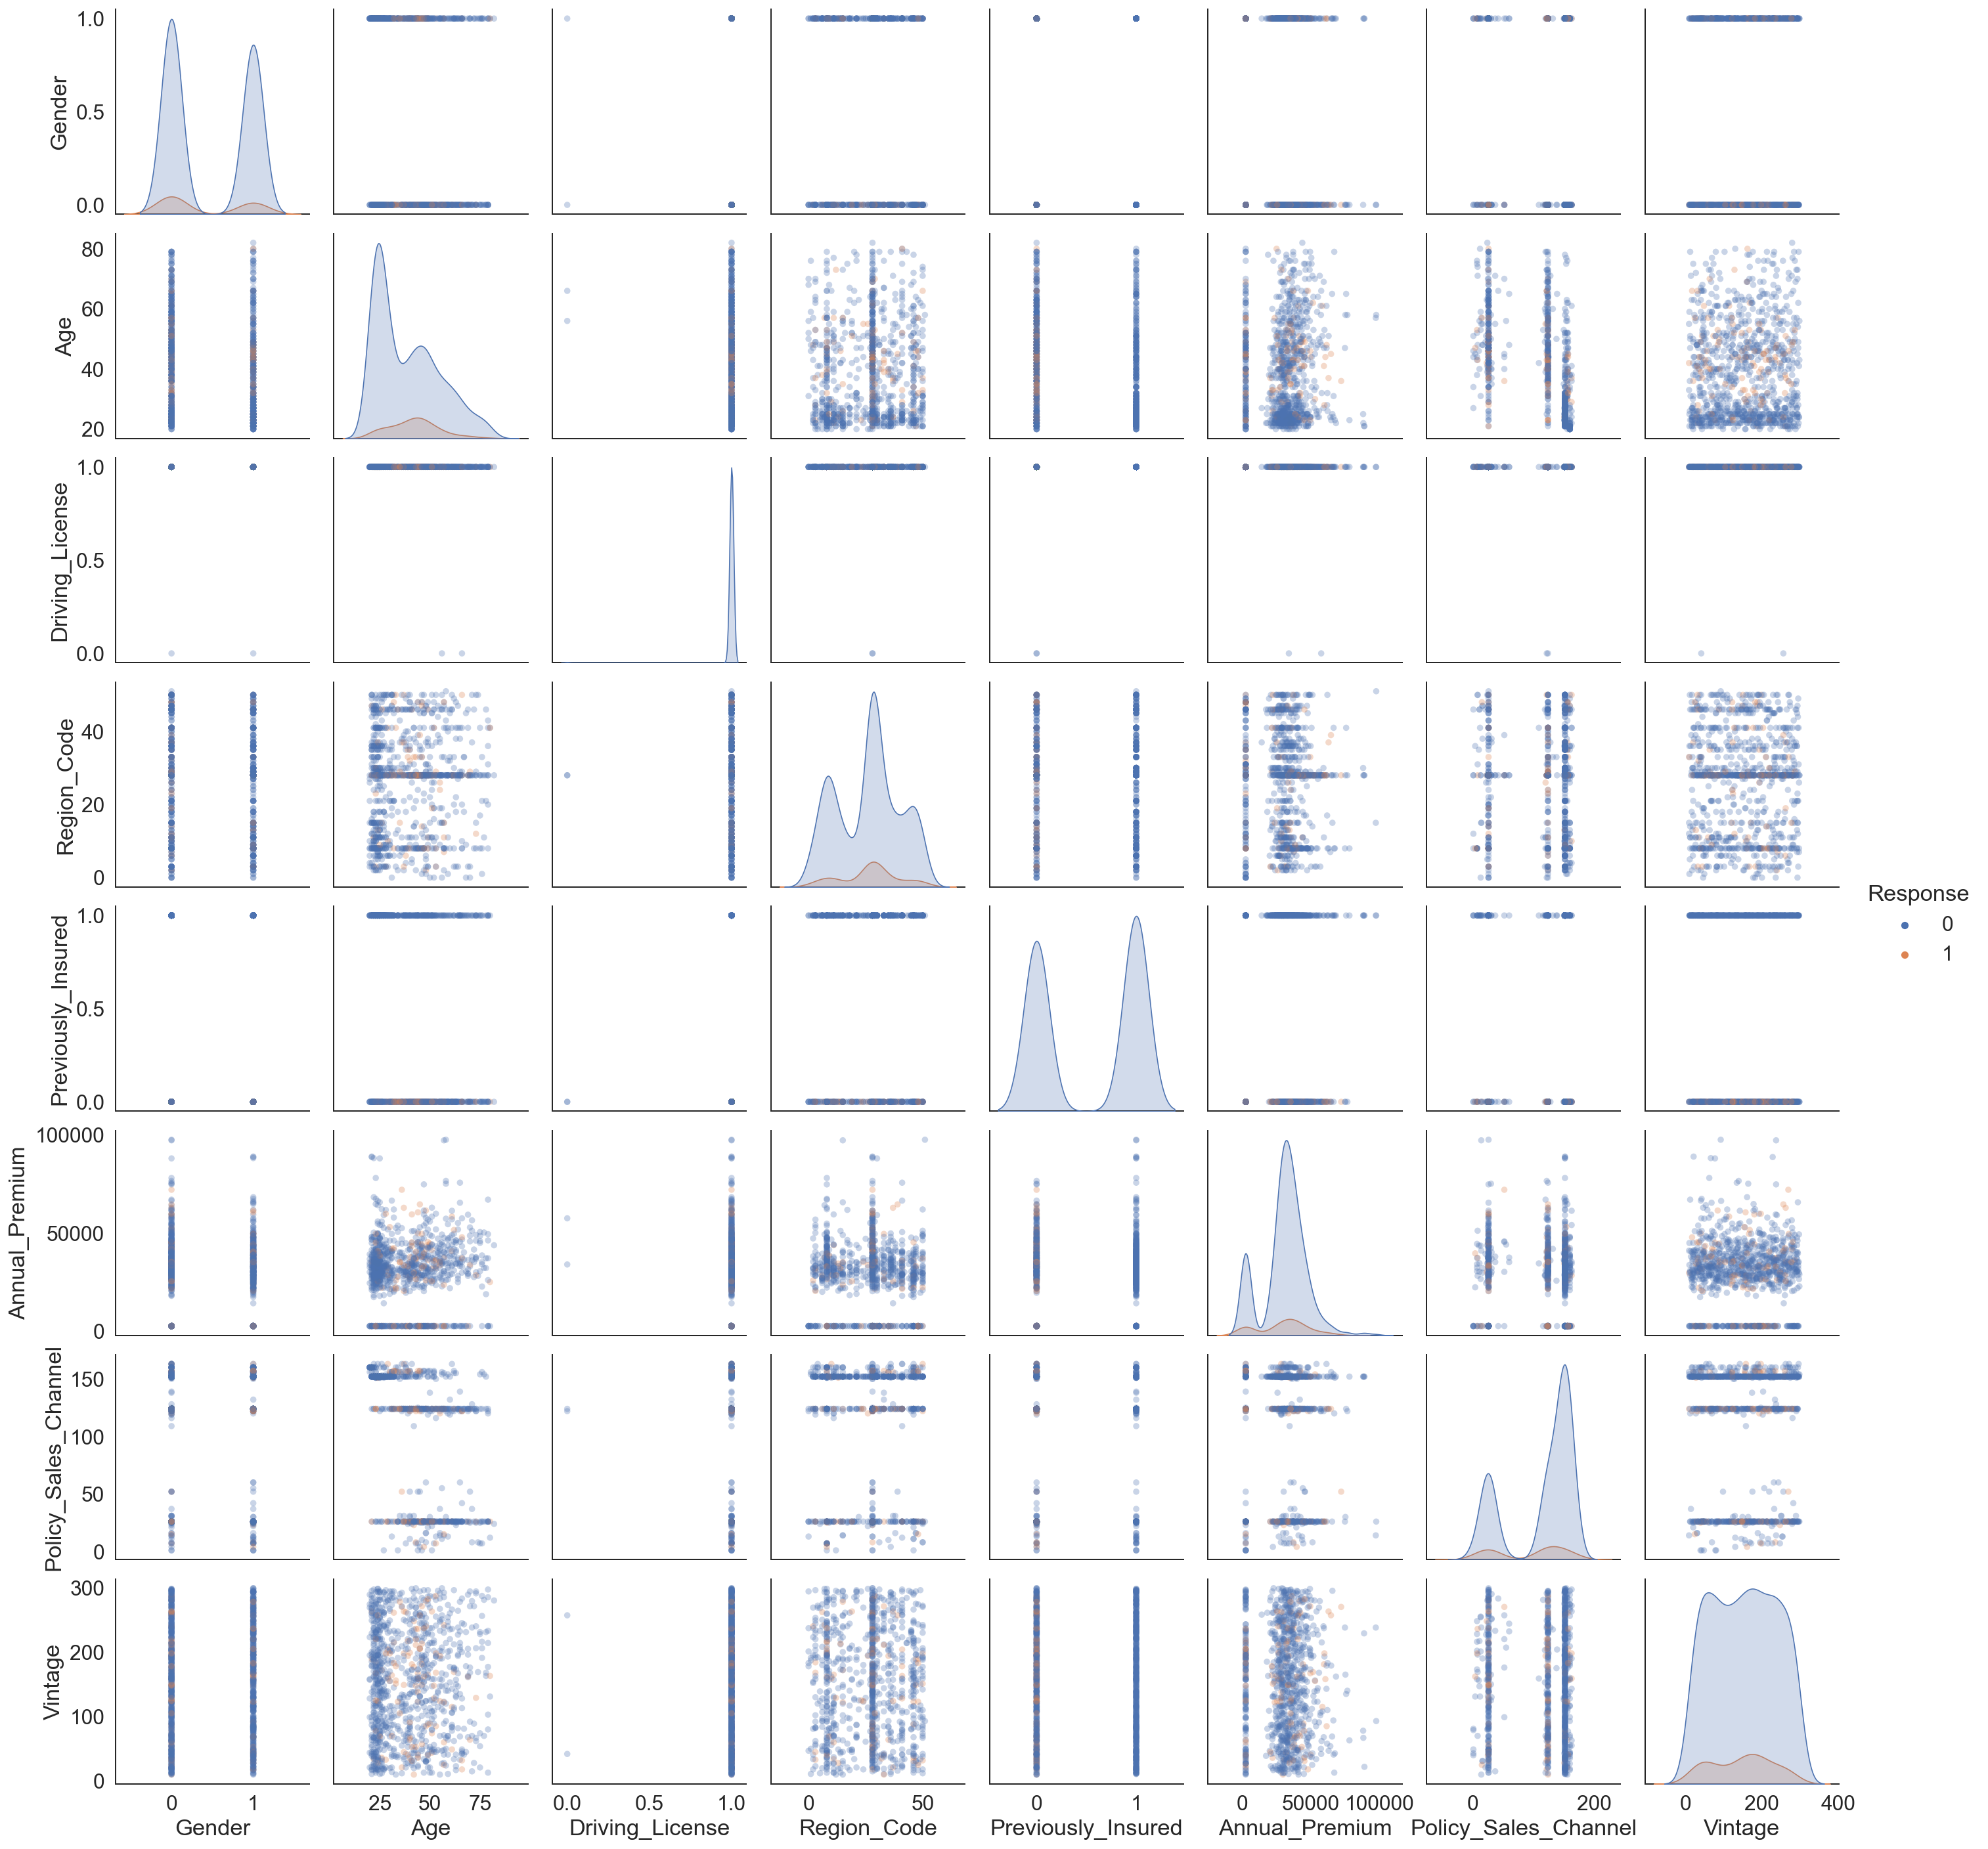

In [15]:
f = plt.figure(figsize=(20,10))
sns.set_context('paper',font_scale = 1.8)

ax = plot_features(df_train)

plt.savefig('feature_pairplot')

## 1) Basic Logistic

### Basic logistic regression on age, driving license, and previously insured.

In [334]:
# Seperate features from label

X = df_train.loc[:,['Age','Driving_License','Previously_Insured']]

y = df_train['Response']

In [335]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [336]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [337]:
# run initial logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  87.74%
Val set score:  87.74%

Precision / Recall
Val F1 score:   0.00%
Precision: 0.0000,   Recall: 0.0000


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [338]:
# analyze error with confusion matrix

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['fail to cross sell', 'cross sell'],
           yticklabels=['fail to cross sell', 'cross sell']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [339]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

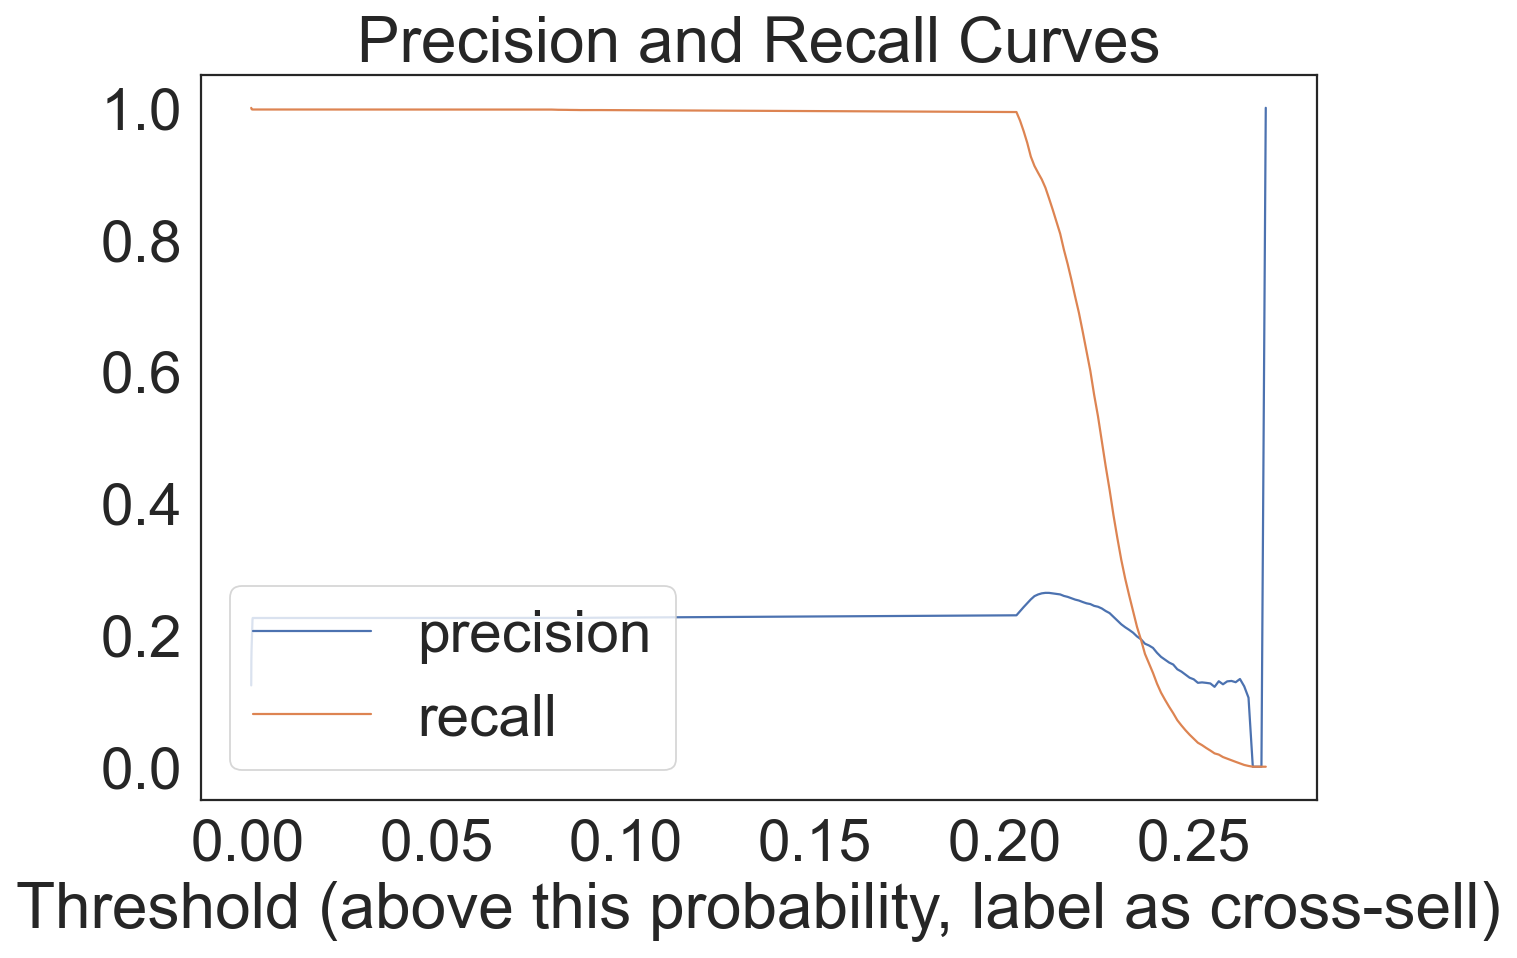

In [340]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [341]:
# let's test thresholds

In [342]:
# using the new threshold of 0.21
y_predict = (lr.predict_proba(X_val)[:,1] > 0.21)
print("Threshold of 0.21:")
print("F1 Score : {:6.4f}, Precision: {:6.4f},  Recall: {:6.4f}, ".format(f1_score(y_val,y_predict), 
                                                     precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Threshold of 0.21:
F1 Score : 0.4063, Precision: 0.2631,  Recall: 0.8915, 


In [343]:
X_train

array([[-1.01917685,  0.04552819,  1.08873217],
       [-1.08361905,  0.04552819, -0.91849954],
       [-0.95473465,  0.04552819,  1.08873217],
       ...,
       [ 0.39855163,  0.04552819, -0.91849954],
       [-0.95473465,  0.04552819,  1.08873217],
       [-0.69696583,  0.04552819, -0.91849954]])

### Basic logistic - All Features

In [379]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [380]:
X.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'young', 'Large_Premium'],
      dtype='object')

In [381]:
# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

In [382]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [383]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [384]:
# run initial logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_val)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_val,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_val, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  87.73%
Val set score:  87.74%

Precision / Recall
Val F1 score:   0.43%
Val F2 score:   0.27%
Precision:  43.48%
Recall:   0.21%


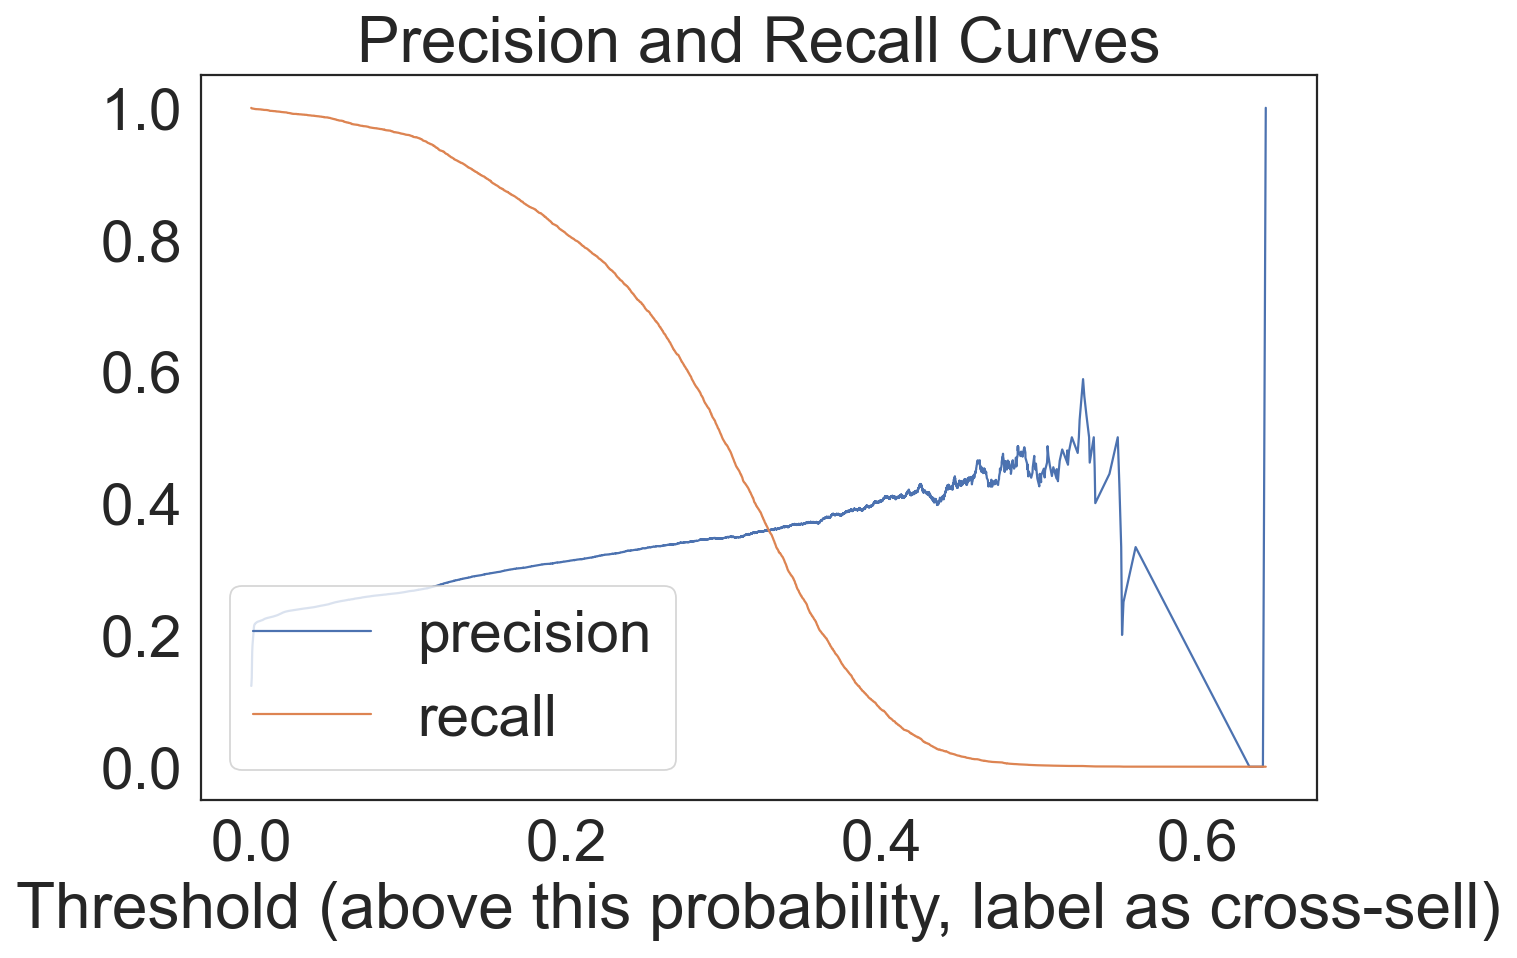

In [385]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [386]:
# using the new threshold of 0.23
y_predict = (lr.predict_proba(X_val)[:,1] > 0.20)
#Validation scores
print("Scores for the Val logistic regression")
print("Val set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_val)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_val,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_val, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_val, y_predict)))

Scores for the Val logistic regression
Val set score:  75.78%

Precision / Recall
Val F1 score:  45.01%
Val F2 score:  61.32%
Precision:  31.18%
Recall:  80.85%


In [387]:
# Test Scores
y_predict = (lr.predict_proba(X_test)[:,1] > 0.2)
print("Scores for the Test logistic regression")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test logistic regression
Test set score:  75.73%

Precision / Recall
Val F1 score:  44.86%
Val F2 score:  61.10%
Precision:  31.09%
Recall:  80.55%


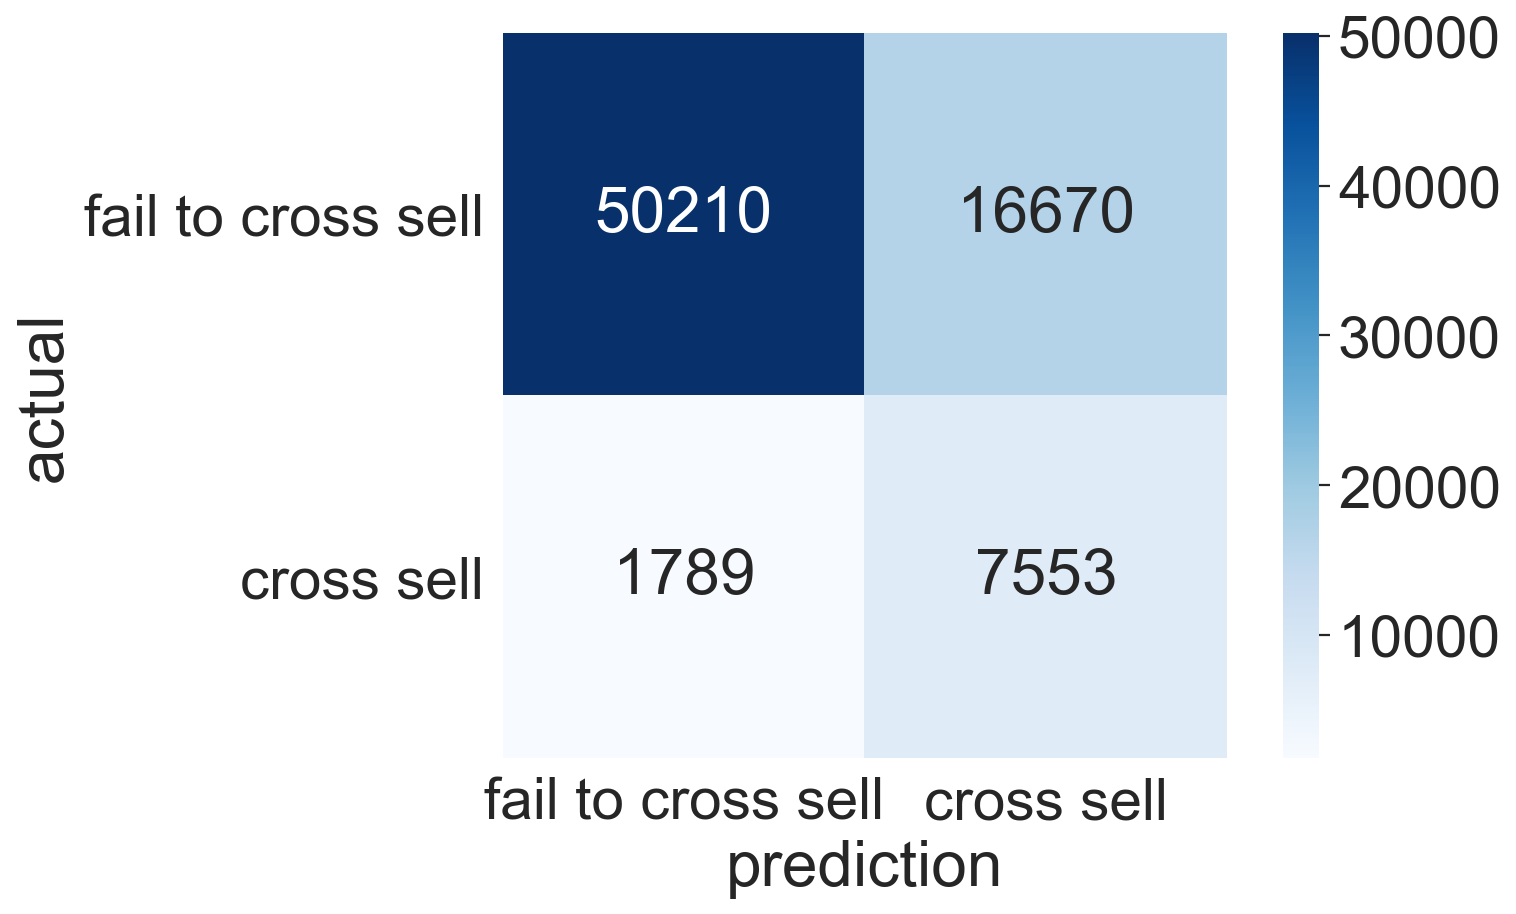

In [388]:
make_confusion_matrix(lr, 0.2)

In [389]:
def make_confusion_matrix_test(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    cross_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(cross_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['fail to cross sell', 'cross sell'],
           yticklabels=['fail to cross sell', 'cross sell']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
    #precision/recall
    print("\nPrecision / Recall")
    print("Accuracy score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))
    print("Test F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
    print("Test F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
    print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
    print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))


Precision / Recall
Accuracy score:  75.73%
Test F1 score:  44.86%
Test F2 score:  61.10%
Precision:  31.09%
Recall:  80.55%


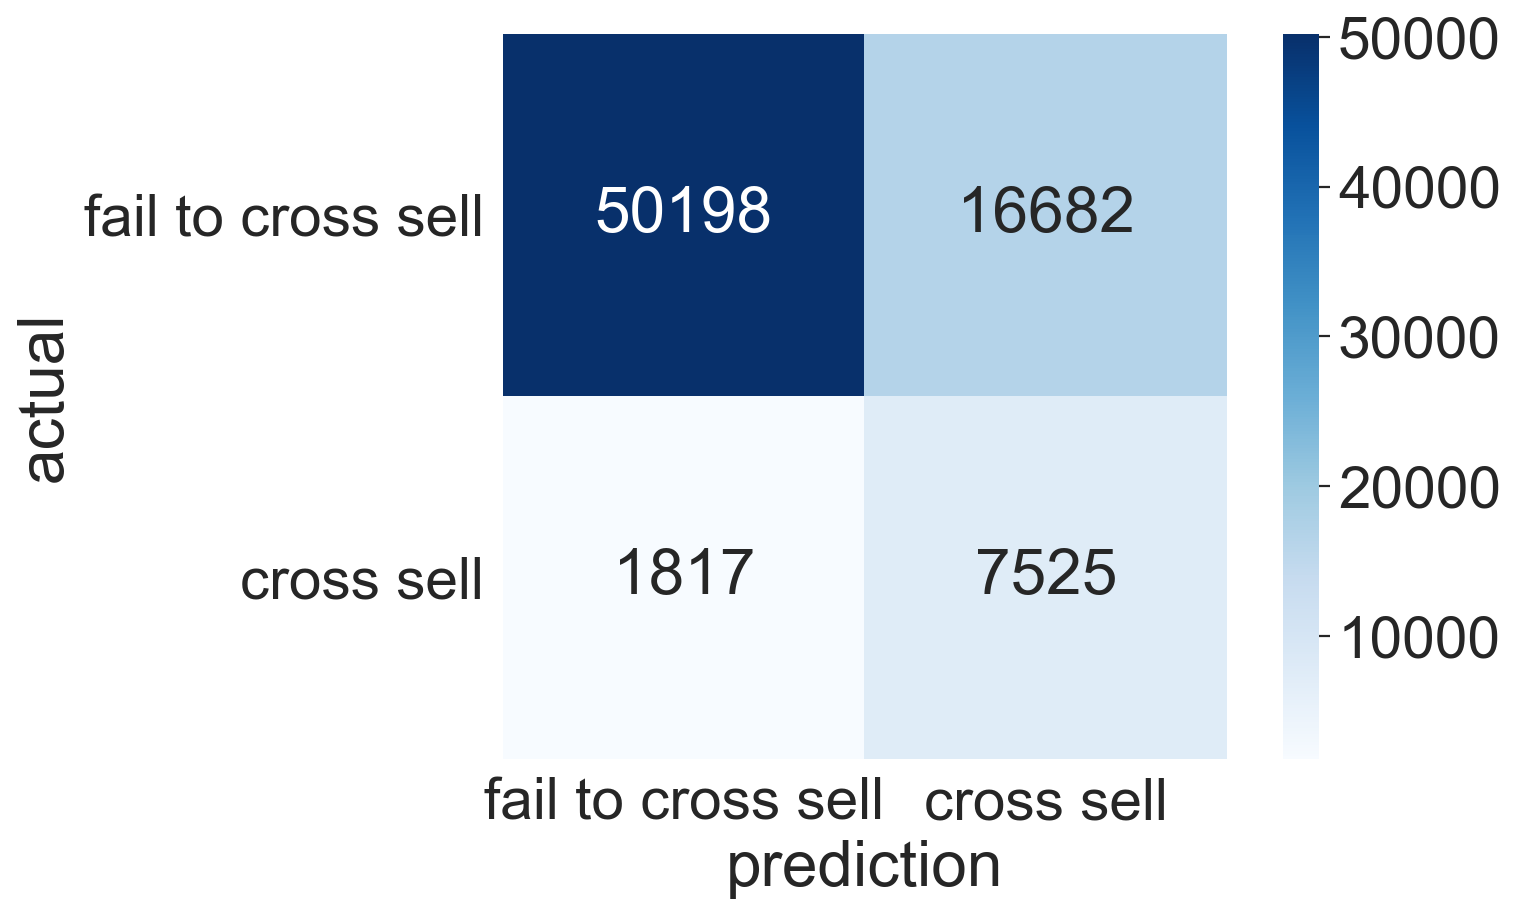

In [390]:
make_confusion_matrix_test(lr, 0.2)

In [391]:
### Analyzing Coefficients

log_odds = lr.coef_[0]
pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

coef
Vehicle_Damage_Yes          0.968827
Policy_Sales_Channel_26.0   0.368678
Region_Code_28.0            0.364267
Policy_Sales_Channel_124.0  0.282503
Region_Code_41.0            0.223639
...                              ...
Policy_Sales_Channel_152.0 -0.147443
young                      -0.284542
Policy_Sales_Channel_160.0 -0.298888
Age                        -0.482977
Previously_Insured         -1.938550

[218 rows x 1 columns]

In [406]:
### Converting from log odds

odds = np.exp(lr.coef_[0])
coefs = pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
coefs.head(3)

coef
Vehicle_Damage_Yes         2.634851
Policy_Sales_Channel_26.0  1.445822
Region_Code_28.0           1.439458

### Logistic All Featurs - Overamspling

#### 1) SMOTE

In [34]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [35]:
# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

In [36]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [37]:
# Oversample training data
X_smoted_tr, y_smoted_tr = SMOTE(random_state=42).fit_sample(X_train,y_train)
Counter(y_smoted_tr)

Counter({0: 200639, 1: 200639})

In [38]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_smoted_tr)
X_val = scaler.transform(X_val)

In [39]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_smoted_tr, y_smoted_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_smoted_tr, y_smoted_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  57.96%
Val set score:  60.15%

Precision / Recall
Val F1 score:   0.30%
Precision: 0.1914,   Recall: 0.6985


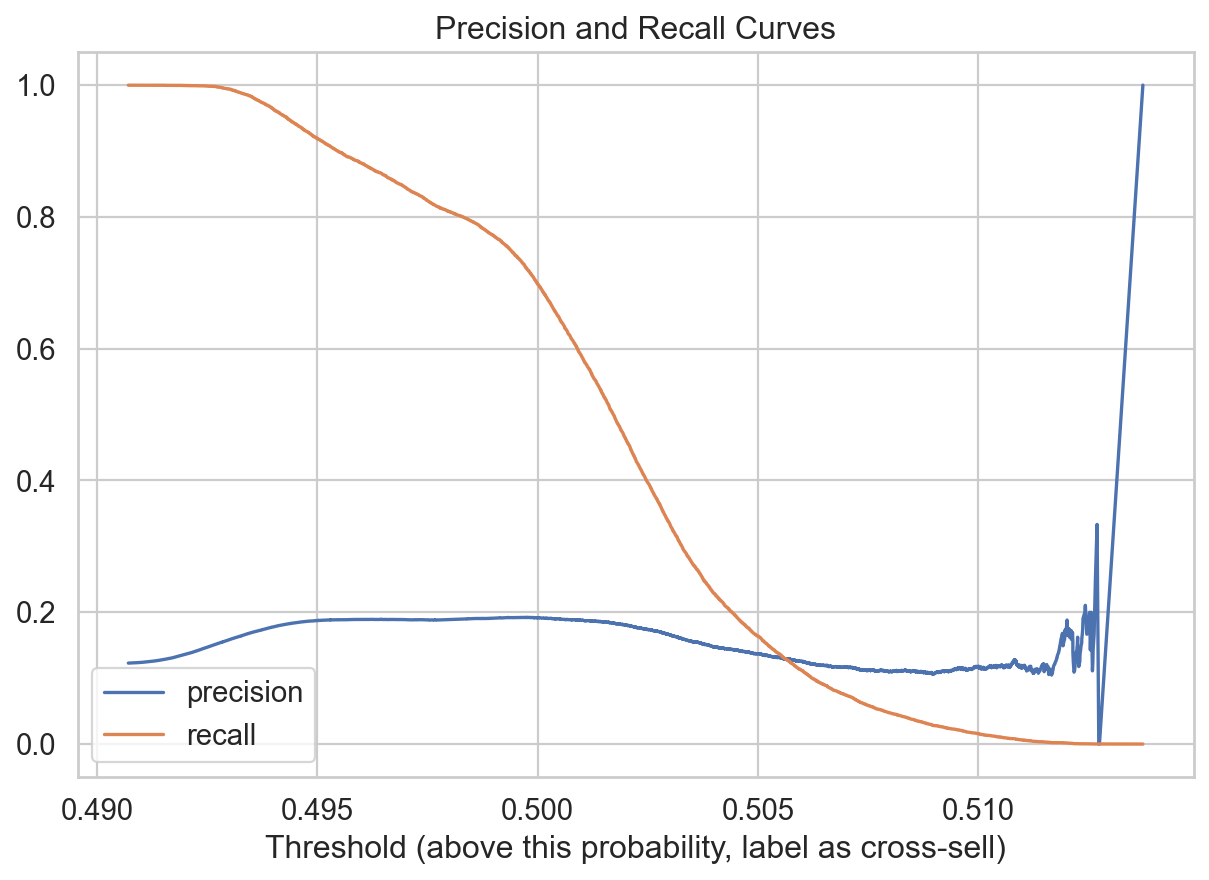

In [40]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

### 2) ADASYN

In [42]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [43]:
# Oversample training data
X_adasyn_tr, y_adasyn_tr = ADASYN(random_state=42).fit_sample(X_train,y_train)
Counter(y_adasyn_tr)

Counter({0: 200639, 1: 203461})

In [44]:
# Scale features 
scaler = StandardScaler()
X_adasyn_tr = scaler.fit_transform(X_adasyn_tr)
X_val = scaler.transform(X_val)

In [45]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_smoted_tr, y_smoted_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_adasyn_tr, y_adasyn_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  66.49%
Val set score:  59.90%

Precision / Recall
Val F1 score:   0.30%
Precision: 0.1912,   Recall: 0.7031


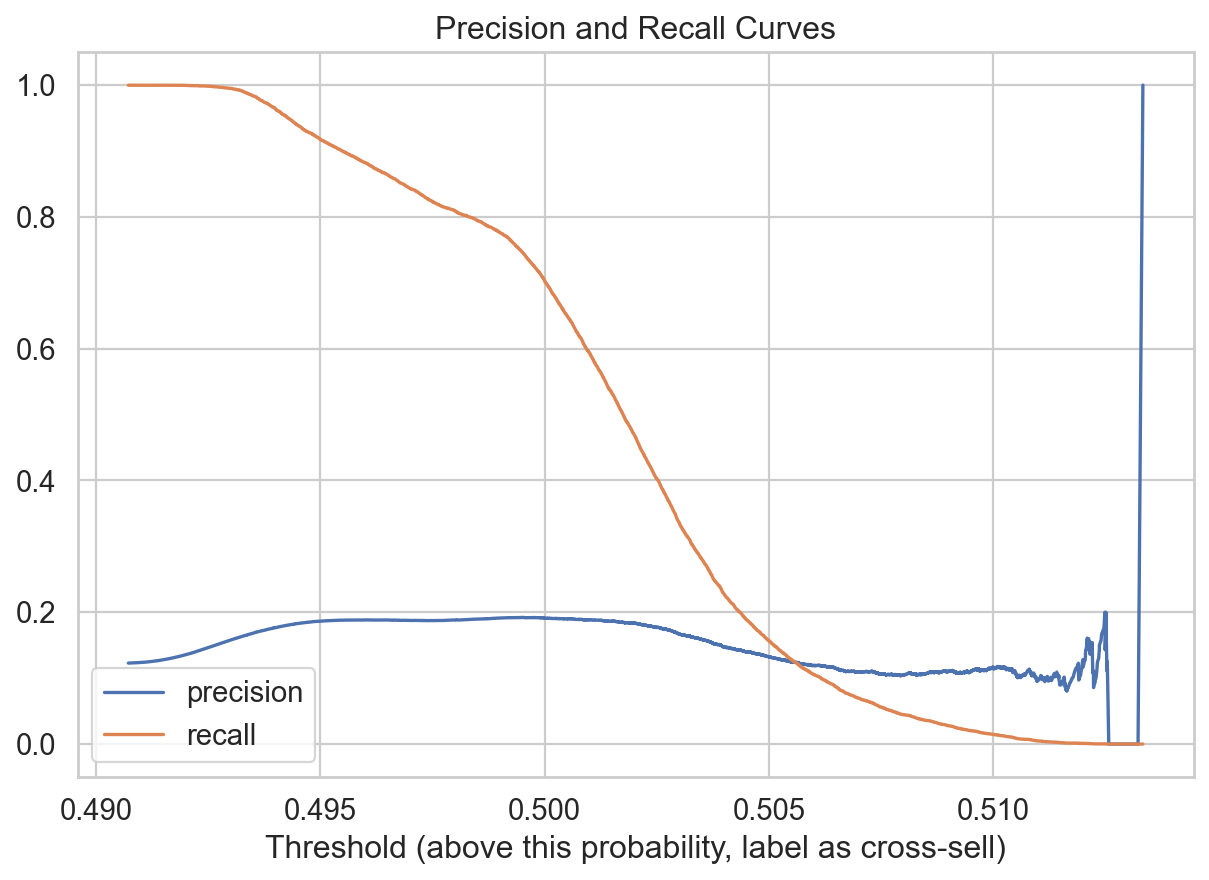

In [46]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [47]:
# using the new threshold of 0.23
y_predict = (lr.predict_proba(X_val)[:,1] > 0.23)
print("Threshold of 0.23:")
print("F1 Score : {:6.4f}, Precision: {:6.4f},  Recall: {:6.4f}, ".format(f1_score(y_val,y_predict), 
                                                     precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Threshold of 0.23:
F1 Score : 0.2184, Precision: 0.1226,  Recall: 1.0000, 


### 3) RandomOverSampler

In [239]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [240]:
# Oversample training data
ros = RandomOverSampler(random_state=0)
X_resampled_tr, y_resampled_tr = ros.fit_sample(X_train,y_train)
Counter(y_resampled_tr)

Counter({0: 200639, 1: 200639})

In [241]:
# Scale features 
scaler = StandardScaler()
X_resampled_tr = scaler.fit_transform(X_resampled_tr)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [242]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_resampled_tr, y_resampled_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_resampled_tr, y_resampled_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  79.85%
Val set score:  69.48%

Precision / Recall
Val F1 score:   0.43%
Precision: 0.2788,   Recall: 0.9392


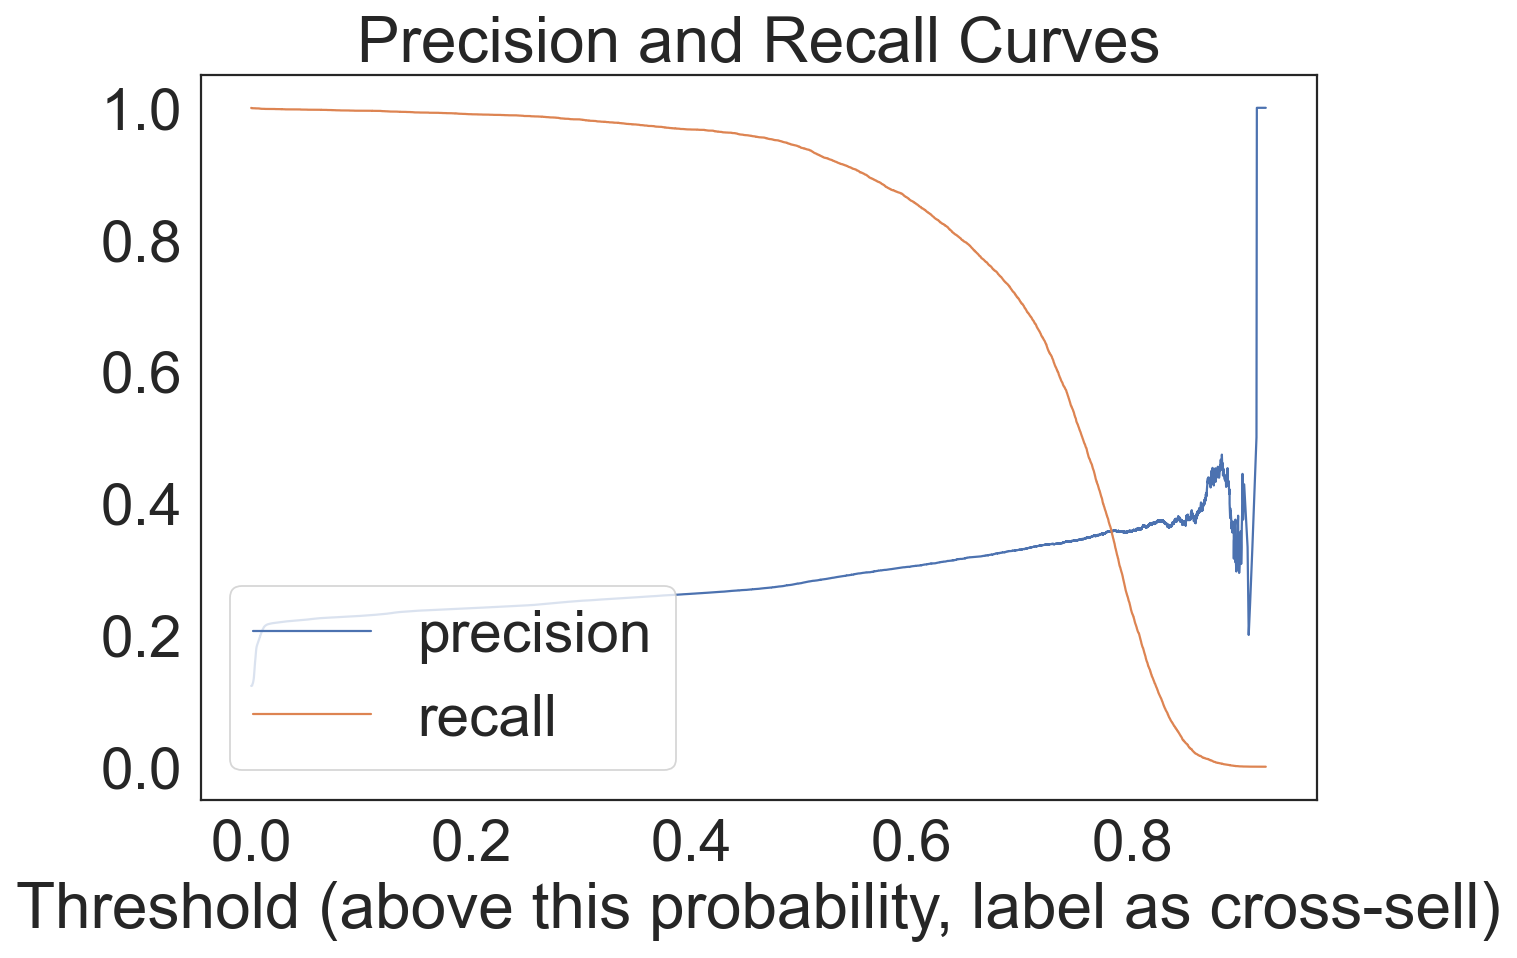

In [243]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [254]:
# using the new threshold 
y_predict = (lr.predict_proba(X_val)[:,1] > 0.65)
print("Threshold of 0.67:")
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))
print("F1 Score : {:6.4f}, Precision: {:6.4f},  Recall: {:6.4f}, ".format(f1_score(y_val,y_predict), 
                                                     precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Threshold of 0.67:
Val set score:  69.48%
F1 Score : 0.4532, Precision: 0.3170,  Recall: 0.7945, 


In [255]:
# Test Scores
y_predict = (lr.predict_proba(X_test)[:,1] > 0.65)
print("Scores for the Test logistic regression")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test logistic regression
Test set score:  76.25%

Precision / Recall
Val F1 score:  44.88%
Val F2 score:  60.54%
Precision:  31.36%
Recall:  78.89%


### Adding grouped sales channels, grouped regions and interaction terms (non improved the logistic)

In [213]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [214]:
X.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'young', 'Large_Premium'],
      dtype='object')

In [215]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1       0   44                1            0                   0   
1            2       0   76                1            1                   0   
2            3       0   47                1            0                   0   
3            4       0   21                1            2                   1   
4            5       1   29                1            3                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105       0   74                1           13                   1   
381105  381106       0   30                1           20                   1   
381106  381107       0   21                1           12                   1   
381107  381108       1   68                1           42                   0   
381108  381109       0   46                1           25                   0   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0                 0               0         40454.0                     0   
1                 1               1         33536.0                     0   
2                 0               0         38294.0                     0   
3                 2               1         28619.0                     1   
4                 2               1         27496.0                     1   
...             ...             ...             ...                   ...   
381104            1               1         30170.0                     0   
381105            2               1         40016.0                     1   
381106            2               1         35118.0                     2   
381107            0               0         44617.0                     3   
381108            1               1         41777.0                     0   

        Vintage  young  Large_Premium  
0           217      0              1  
1           183      0              1  
2            27      0              1  
3           203      1              1  
4            39      1              1  
...         ...    ...            ...  
381104       88      0              1  
381105      131      1              1  
381106      161      1              1  
381107       74      0              1  
381108      237      0              1  

[381109 rows x 13 columns]

In [216]:
X.Gender

0         0
1         0
2         0
3         0
4         1
         ..
381104    0
381105    0
381106    0
381107    1
381108    0
Name: Gender, Length: 381109, dtype: int64

In [217]:
# Create Interaction Terms
X['AgeXVintage'] = X['Age'] * X['Vintage']
X['youngXLarge_Premium'] = X['young'] * X['Large_Premium']
X['Vehicle_DamageXVehicle_Age'] = X['Vehicle_Damage'] * X['Vehicle_Age']
X['GenderXAge'] = X['Gender'] * X['Age']

In [218]:
# #Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [219]:
# Oversample training data
ros = RandomOverSampler(random_state=0)
X_resampled_tr, y_resampled_tr = ros.fit_sample(X_train,y_train)
Counter(y_resampled_tr)

Counter({0: 200639, 1: 200639})

In [220]:
# Scale features 
scaler = StandardScaler()
X_resampled_tr = scaler.fit_transform(X_resampled_tr)
X_val = scaler.transform(X_val)

In [221]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_resampled_tr, y_resampled_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_resampled_tr, y_resampled_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  78.33%
Val set score:  64.09%

Precision / Recall
Val F1 score:   0.40%
Precision: 0.2506,   Recall: 0.9695


#### Improving with grid search

In [106]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [107]:
# Oversample training data
ros = RandomOverSampler(random_state=0)
X_resampled_tr, y_resampled_tr = ros.fit_sample(X_train,y_train)
Counter(y_resampled_tr)

# Scale features 
scaler = StandardScaler()
X_resampled_tr = scaler.fit_transform(X_resampled_tr)
X_val = scaler.transform(X_val)

In [56]:
define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [57]:
define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [31]:
#Pickle and load grid search results
filename = 'logistic_grid_search.pkl'
pickle.dump(grid_result, open(filename, 'wb'))

In [32]:
# Load pickle 
path = r"C:\Users\Andrew\Documents\Metis\Cross_Sell_Prediction\Pickled"
filename = path+'\\logistic_grid_search.pkl'
grid_result = pickle.load(open(filename, 'rb'))

In [33]:
#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
   print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.877436 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.877393 (0.000060) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.877429 (0.000046) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.877436 (0.000019) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.877407 (0.000063) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.877429 (0.000046) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.877436 (0.000019) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.877401 (0.000057) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.877429 (0.000046) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.877436 (0.000019) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.877401 (0.000058) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.877429 (0.000046) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.877436 (0.000019) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.877436 (0.000038) wit

In [108]:
# run logistic regression with these optimized parameters
lr = LogisticRegression(C = 100, penalty = 'l2', solver = 'liblinear')
lr.fit(X_resampled_tr, y_resampled_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_resampled_tr, y_resampled_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  79.91%
Val set score:  69.46%

Precision / Recall
Val F1 score:   0.43%
Precision: 0.2784,   Recall: 0.9371


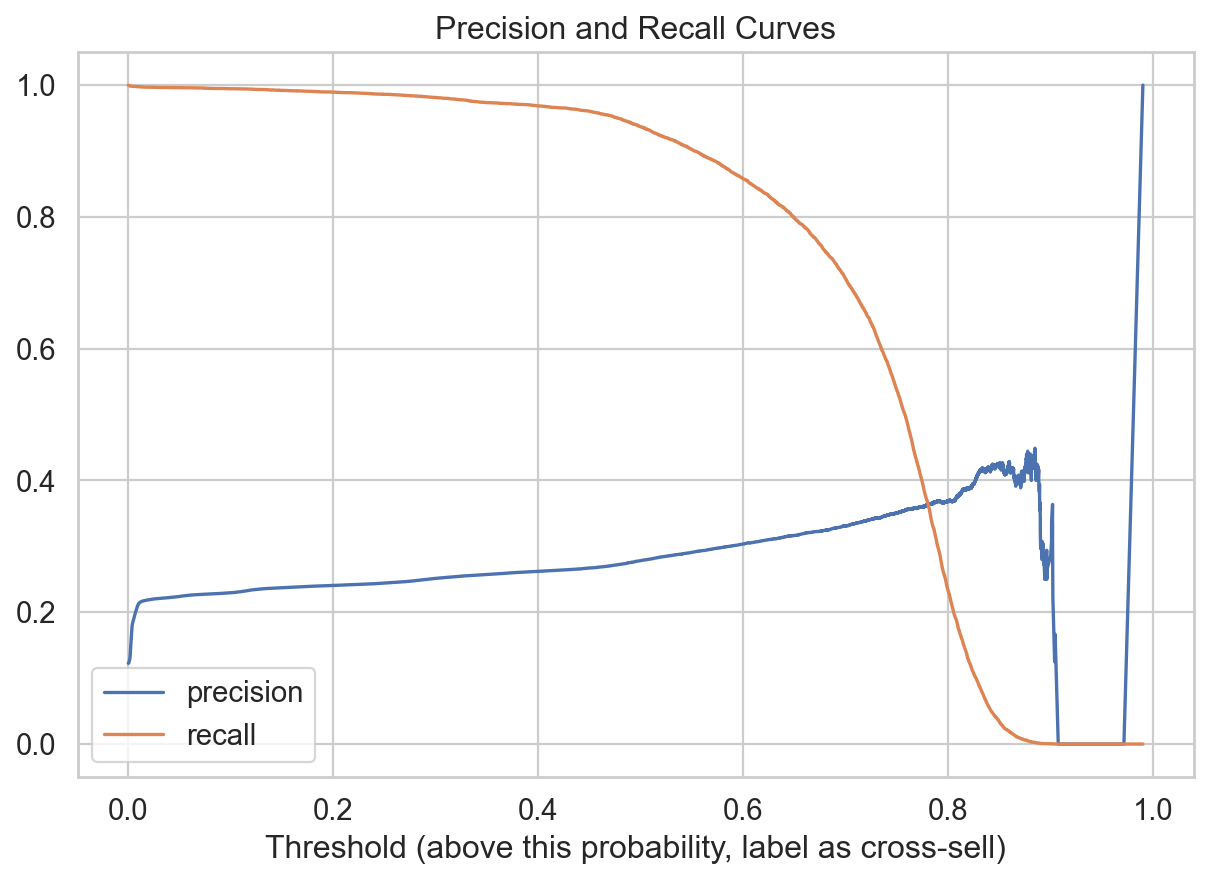

In [109]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as cross-sell)');
plt.title('Precision and Recall Curves');

In [118]:
# using the new threshold 
y_predict = (lr.predict_proba(X_val)[:,1] > 0.66)
print("Threshold of 0.67:")
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))
print("F1 Score : {:6.4f}, Precision: {:6.4f},  Recall: {:6.4f}, ".format(f1_score(y_val,y_predict), 
                                                     precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Threshold of 0.67:
Val set score:  69.46%
F1 Score : 0.4544, Precision: 0.3198,  Recall: 0.7844, 


## 2) KNN

### Basic KNN on age, driving license, and previously insured.

In [161]:
# Seperate features from label

X = df_train.loc[:,['Age','Driving_License','Previously_Insured']]

y = df_train['Response']

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [162]:
# run initial KNN Val Scores
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_val)

#scores
print("Scores for the val knn")
print("Training score: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*knn.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(knn.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the val knn
Training score:  85.61%
Val set score:  85.62%

Precision / Recall
Val F1 score:   0.16%
Precision: 0.2828,   Recall: 0.1126


In [163]:
# Test Scores
y_predict = knn.predict(X_test)

print("Scores for the Test knn")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test knn
Test set score:  85.50%

Precision / Recall
Val F1 score:  16.03%
Val F2 score:  12.81%
Precision:  27.59%
Recall:  11.29%


In [164]:
# run KNN with fewer K
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_val)

#scores
print("Scores for the val knn")
print("Training score: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*knn.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(knn.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the val knn
Training score:  85.39%
Val set score:  85.30%

Precision / Recall
Val F1 score:   0.20%
Precision: 0.3004,   Recall: 0.1503


In [166]:
# Test Scores
y_predict = knn.predict(X_test)

print("Scores for the Test knn")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test knn
Test set score:  85.32%

Precision / Recall
Val F1 score:  20.07%
Val F2 score:  16.72%
Precision:  30.17%
Recall:  15.04%


### Oversampling

In [271]:
# Seperate features from label

X = df_train.loc[:,['Age','Driving_License','Previously_Insured']]

y = df_train['Response']

In [272]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [273]:
# Oversample training data
ros = RandomOverSampler(random_state=0)
X_resampled_tr, y_resampled_tr = ros.fit_sample(X_train,y_train)
Counter(y_resampled_tr)

Counter({1: 200639, 0: 200639})

In [275]:
# run initial KNN 
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_resampled_tr, y_resampled_tr)
y_predict = knn.predict(X_val)

#scores
print("Scores for the knn")
print("Training score: {:6.2f}%".format(100*knn.score(X_resampled_tr, y_resampled_tr)))
print("Val set score: {:6.2f}%".format(100*knn.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(knn.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(100*precision_score(y_val, y_predict), 
                                                     100*recall_score(y_val, y_predict)))

Scores for the knn
Training score:  74.86%
Val set score:  72.27%

Precision / Recall
Val F1 score:  41.11%
Precision: 27.7857,   Recall: 78.9553


#### Use random grid search to optimize oversampled dataset

In [126]:
# specify "parameter distributions" rather than a "parameter grid"
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=k_range, weights=weight_options)

In [127]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [128]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=42)
rand.fit(X_resampled_tr, y_resampled_tr)
rand.cv_results_

In [129]:
# Pickle search results

filename = "best_knn_model"
pickle.dump(rand ,open(filename,'wb'))

In [130]:
# Load search results

rand = pickle.load(open(filename,'rb'))

In [131]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

In [276]:
# run best KNN 
knn = KNeighborsClassifier(n_neighbors=29,weights='distance')
knn.fit(X_resampled_tr, y_resampled_tr)
y_predict = knn.predict(X_val)

#scores
print("Scores for the knn")
print("Training score: {:6.2f}%".format(100*knn.score(X_resampled_tr, y_resampled_tr)))
print("Val set score: {:6.2f}%".format(100*knn.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(knn.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the knn
Training score:  75.84%
Val set score:  68.82%

Precision / Recall
Val F1 score:   0.40%
Precision: 0.2632,   Recall: 0.8583


In [277]:
# Test Scores
y_predict = knn.predict(X_test)

print("Scores for the Test knn")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test knn
Test set score:  68.80%

Precision / Recall
Val F1 score:  40.36%
Val F2 score:  59.25%
Precision:  26.35%
Recall:  86.13%


## 3) Naive Bayes

### Start with Gaussian (continuous only)

In [16]:
# Seperate features from label

X = df_train.loc[:,['Age','Annual_Premium','Vintage']]

y = df_train['Response']

In [17]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [18]:
# Create Gaussian Model
nb = GaussianNB()
nb.fit(X_train, y_train)
# Score model
nb.score(X_val, y_val)

0.8768072210123061

In [19]:
# Further Metrics
y_predict = nb.predict(X_val)
#scores
print("Scores for the gaussian bayes")
print("Training score: {:6.2f}%".format(100*nb.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*nb.score(X_val, y_val)))
#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(nb.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the gaussian bayes
Training score:  87.68%
Val set score:  87.68%

Precision / Recall
Val F1 score:   0.00%
Precision: 0.1923,   Recall: 0.0016


In [20]:
# Test Metrics
y_predict = nb.predict(X_test)
print("Scores for the Test Gaussian")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test Gaussian
Test set score:  87.69%

Precision / Recall
Val F1 score:   0.40%
Val F2 score:   0.25%
Precision:  24.68%
Recall:   0.20%


#### Apply over sampling 

In [283]:
# Over sample minority class
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
Counter(y_resampled)

Counter({0: 200639, 1: 200639})

In [284]:
# Create Gaussian Model
nb = GaussianNB()
nb.fit(X_resampled, y_resampled)
# Score model
nb.score(X_val, y_val)

0.5908005562698434

In [285]:
# Further Metrics
y_predict = nb.predict(X_val)
#scores
print("Scores for the gaussian bayes")
print("Training score: {:6.2f}%".format(100*nb.score(X_resampled, y_resampled)))
print("Val set score: {:6.2f}%".format(100*nb.score(X_val, y_val)))
#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(nb.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the gaussian bayes
Training score:  64.03%
Val set score:  59.08%

Precision / Recall
Val F1 score:   0.30%
Precision: 0.1893,   Recall: 0.7127


In [287]:
# Test Metrics
y_predict = nb.predict(X_test)
print("Scores for the Test knn")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test knn
Test set score:  58.77%

Precision / Recall
Val F1 score:  29.73%
Val F2 score:  45.69%
Precision:  18.79%
Recall:  71.16%


### Categorical Features 

In [172]:
# Seperate features from label

X = df_train.loc[:,['Gender','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage']]

y = df_train['Response']

In [173]:
# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage'],drop_first=True)

In [174]:
X

Region_Code  Gender_1  Previously_Insured_1  Vehicle_Age_< 1 Year  \
0              28.0         0                     0                     0   
1               3.0         0                     0                     0   
2              28.0         0                     0                     0   
3              11.0         0                     1                     1   
4              41.0         1                     1                     1   
...             ...       ...                   ...                   ...   
381104         26.0         0                     1                     0   
381105         37.0         0                     1                     1   
381106         30.0         0                     1                     1   
381107         14.0         1                     0                     0   
381108         29.0         0                     0                     0   

        Vehicle_Age_> 2 Years  Vehicle_Damage_Yes  
0                           1                   1  
1                           0                   0  
2                           1                   1  
3                           0                   0  
4                           0                   0  
...                       ...                 ...  
381104                      0                   0  
381105                      0                   0  
381106                      0                   0  
381107                      1                   1  
381108                      0                   0  

[381109 rows x 6 columns]

In [175]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [176]:
# Create Categorical NB Model
categorical_nb = CategoricalNB()
categorical_nb.fit(X_train, y_train)

CategoricalNB()

In [177]:
# Further Metrics
y_predict = categorical_nb.predict(X_val)
#scores
print("Scores for the gaussian bayes")
print("Training score: {:6.2f}%".format(100*categorical_nb.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*categorical_nb.score(X_val, y_val)))
#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(categorical_nb.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the gaussian bayes
Training score:  78.51%
Val set score:  78.40%

Precision / Recall
Val F1 score:   0.38%
Precision: 0.2916,   Recall: 0.5381


In [179]:
# Test Metrics
y_predict = categorical_nb.predict(X_test)
print("Scores for the Test categorical nb")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test knn
Test set score:  78.32%

Precision / Recall
Val F1 score:  37.96%
Val F2 score:  46.06%
Precision:  29.35%
Recall:  53.71%


### Apply oversampling

In [294]:
# Seperate features from label

X = df_train.loc[:,['Gender','Region_Code','Previously_Insured','Vehicle_Age','Vehicle_Damage']]

y = df_train['Response']

# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Previously_Insured','Vehicle_Age','Vehicle_Damage'],drop_first=True)

In [295]:
# Over sample minority class
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
Counter(y_resampled)

Counter({0: 200718, 1: 200718})

In [296]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [297]:
# Create Categorical NB Model
categorical_nb = CategoricalNB()
categorical_nb.fit(X_train, y_train)

CategoricalNB()

In [298]:
# Further Metrics
y_predict = categorical_nb.predict(X_val)
#scores
print("Scores for the categorical bayes")
print("Training score: {:6.2f}%".format(100*categorical_nb.score(X_resampled, y_resampled)))
print("Val set score: {:6.2f}%".format(100*categorical_nb.score(X_val, y_val)))
#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(categorical_nb.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the categorical bayes
Training score:  67.69%
Val set score:  78.59%

Precision / Recall
Val F1 score:   0.38%
Precision: 0.2961,   Recall: 0.5294


In [299]:
# Test Metrics
y_predict = categorical_nb.predict(X_test)
print("Scores for the Test categorical nb")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test categorical nb
Test set score:  78.60%

Precision / Recall
Val F1 score:  37.71%
Val F2 score:  45.73%
Precision:  29.18%
Recall:  53.28%


## 4) Random Forest

### All variables

In [81]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [82]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1       0   44                1            0                   0   
1            2       0   76                1            1                   0   
2            3       0   47                1            0                   0   
3            4       0   21                1            2                   1   
4            5       1   29                1            3                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105       0   74                1           13                   1   
381105  381106       0   30                1           20                   1   
381106  381107       0   21                1           12                   1   
381107  381108       1   68                1           42                   0   
381108  381109       0   46                1           25                   0   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0                 0               0         40454.0                     0   
1                 1               1         33536.0                     0   
2                 0               0         38294.0                     0   
3                 2               1         28619.0                     1   
4                 2               1         27496.0                     1   
...             ...             ...             ...                   ...   
381104            1               1         30170.0                     0   
381105            2               1         40016.0                     1   
381106            2               1         35118.0                     2   
381107            0               0         44617.0                     3   
381108            1               1         41777.0                     0   

        Vintage  young  Large_Premium  
0           217      0              1  
1           183      0              1  
2            27      0              1  
3           203      1              1  
4            39      1              1  
...         ...    ...            ...  
381104       88      0              1  
381105      131      1              1  
381106      161      1              1  
381107       74      0              1  
381108      237      0              1  

[381109 rows x 13 columns]

In [83]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [84]:
# run random forest
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_predict = clf.predict(X_val)

#scores
print("Scores for the clf")
print("Training score: {:6.2f}%".format(100*clf.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*clf.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(clf.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the clf
Training score: 100.00%
Val set score:  87.25%

Precision / Recall
Val F1 score:   0.12%
Precision: 0.3909,   Recall: 0.0725


In [86]:
# Test Metrics
y_predict = clf.predict(X_test)
print("Scores for the Test clf")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test clf
Test set score:  87.23%

Precision / Recall
Val F1 score:  12.81%
Val F2 score:   9.12%
Precision:  39.26%
Recall:   7.65%


### Apply oversampling

In [87]:
# Over sample minority class
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
Counter(y_resampled)

Counter({0: 200639, 1: 200639})

In [88]:
# run random forest
clf = RandomForestClassifier()
clf.fit(X_resampled, y_resampled)
y_predict = clf.predict(X_val)

#scores
print("Scores for the clf")
print("Training score: {:6.2f}%".format(100*clf.score(X_resampled, y_resampled)))
print("Val set score: {:6.2f}%".format(100*clf.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(clf.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the clf
Training score: 100.00%
Val set score:  85.59%

Precision / Recall
Val F1 score:   0.27%
Precision: 0.3541,   Recall: 0.2132


In [90]:
# Test Metrics
y_predict = clf.predict(X_test)
print("Scores for the Test clf")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Test F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Test F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the Test clf
Test set score:  85.53%

Precision / Recall
Test F1 score:  26.85%
Test F2 score:  23.48%
Precision:  35.30%
Recall:  21.67%


## 5) XG Boost

### Inital XG Boost

In [185]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [186]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1       0   44                1            0                   0   
1            2       0   76                1            1                   0   
2            3       0   47                1            0                   0   
3            4       0   21                1            2                   1   
4            5       1   29                1            3                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105       0   74                1           13                   1   
381105  381106       0   30                1           20                   1   
381106  381107       0   21                1           12                   1   
381107  381108       1   68                1           42                   0   
381108  381109       0   46                1           25                   0   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0                 0               0         40454.0                     0   
1                 1               1         33536.0                     0   
2                 0               0         38294.0                     0   
3                 2               1         28619.0                     1   
4                 2               1         27496.0                     1   
...             ...             ...             ...                   ...   
381104            1               1         30170.0                     0   
381105            2               1         40016.0                     1   
381106            2               1         35118.0                     2   
381107            0               0         44617.0                     3   
381108            1               1         41777.0                     0   

        Vintage  young  Large_Premium  
0           217      0              1  
1           183      0              1  
2            27      0              1  
3           203      1              1  
4            39      1              1  
...         ...    ...            ...  
381104       88      0              1  
381105      131      1              1  
381106      161      1              1  
381107       74      0              1  
381108      237      0              1  

[381109 rows x 13 columns]

In [187]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

#### Eval Metric: Error

In [188]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

In [211]:
#scores
print("Scores for the XGB model")

print("\nAccuracy score: {:6.2f}%".format(100*accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.2f}%".format(100*f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F2 score: {:6.2f}%".format(100*fbeta_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),beta=2.0)))
print("Precision score: {:6.2f}%".format(100*precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.2f}%".format(100*recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.2f}%".format(100*roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model

Accuracy score:  87.75%
F1 score:   1.08%
F2 score:   0.68%
Precision score:  53.12%
Recall score:   0.55%
AUC:  50.24%


#### Eval Metric: AUC

In [190]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

In [191]:
#scores
print("Scores for the XGB model")

print("\nAccuracy score: {:6.2f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.2f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Precision score: {:6.2f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.2f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.2f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model

Accuracy score:   0.88%
F1 score:   0.01%
Precision score:   0.53%
Recall score:   0.01%
AUC:   0.50%


### Accounting for imbalanced data (directly changing the scale_pos_weight)

In [140]:
# Seperate features from label

X = df_train.drop(columns=['Response','Large_Premium','young'])

y = df_train['Response']

In [141]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1       0   44                1            0                   0   
1            2       0   76                1            1                   0   
2            3       0   47                1            0                   0   
3            4       0   21                1            2                   1   
4            5       1   29                1            3                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105       0   74                1           13                   1   
381105  381106       0   30                1           20                   1   
381106  381107       0   21                1           12                   1   
381107  381108       1   68                1           42                   0   
381108  381109       0   46                1           25                   0   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0                 0               0         40454.0                     0   
1                 1               1         33536.0                     0   
2                 0               0         38294.0                     0   
3                 2               1         28619.0                     1   
4                 2               1         27496.0                     1   
...             ...             ...             ...                   ...   
381104            1               1         30170.0                     0   
381105            2               1         40016.0                     1   
381106            2               1         35118.0                     2   
381107            0               0         44617.0                     3   
381108            1               1         41777.0                     0   

        Vintage  
0           217  
1           183  
2            27  
3           203  
4            39  
...         ...  
381104       88  
381105      131  
381106      161  
381107       74  
381108      237  

[381109 rows x 11 columns]

In [146]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [147]:
# calculating small_pos_weight
# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.159


In [148]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=8,
                        objective='binary:logistic', 
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        scale_pos_weight = 7.159,
                        n_jobs = -1
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=30000, n_jobs=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=7.159,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [150]:
# Pickle model
path = r"C:\Users\Andrew\Documents\Metis\Cross_Sell_Prediction\Pickled"
filename = path+'\\XGB_binlog_weighted.pkl'
pickle.dump(gbm, open(filename, 'wb'))

#### Pickled section

In [151]:
# Load pickle
path = r"C:\Users\Andrew\Documents\Metis\Cross_Sell_Prediction\Pickled"
filename = path+'\\XGB_binlog_weighted.pkl'
gbm = pickle.load(open(filename, 'rb'))

In [154]:
#scores
print("Scores for the XGB model test data")

print("\nAccuracy score: {:6.4f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.4f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F2 score: {:6.2f}%".format(100*fbeta_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),beta=2.0)))
print("Precision score: {:6.4f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.4f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.4f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model test data

Accuracy score: 0.7985%
F1 score: 0.4229%
F2 score:  51.51%
Precision score: 0.3258%
Recall score: 0.6025%
AUC: 0.7142%


### Accounting for imbalanced data (directly changing the scale_pos_weight), includes bimodal terms ('young' and 'large premium'

In [196]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [197]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1       0   44                1            0                   0   
1            2       0   76                1            1                   0   
2            3       0   47                1            0                   0   
3            4       0   21                1            2                   1   
4            5       1   29                1            3                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105       0   74                1           13                   1   
381105  381106       0   30                1           20                   1   
381106  381107       0   21                1           12                   1   
381107  381108       1   68                1           42                   0   
381108  381109       0   46                1           25                   0   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0                 0               0         40454.0                     0   
1                 1               1         33536.0                     0   
2                 0               0         38294.0                     0   
3                 2               1         28619.0                     1   
4                 2               1         27496.0                     1   
...             ...             ...             ...                   ...   
381104            1               1         30170.0                     0   
381105            2               1         40016.0                     1   
381106            2               1         35118.0                     2   
381107            0               0         44617.0                     3   
381108            1               1         41777.0                     0   

        Vintage  young  Large_Premium  
0           217      0              1  
1           183      0              1  
2            27      0              1  
3           203      1              1  
4            39      1              1  
...         ...    ...            ...  
381104       88      0              1  
381105      131      1              1  
381106      161      1              1  
381107       74      0              1  
381108      237      0              1  

[381109 rows x 13 columns]

In [198]:
# split training data into training and validate
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [199]:
# calculating small_pos_weight
# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.159


In [200]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=8,
                        objective='binary:logistic', 
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        scale_pos_weight = 7.159,
                        n_jobs = -1
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', 
                    early_stopping_rounds=50,
                    verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=30000, n_jobs=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=7.159,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [201]:
#scores
print("Scores for the XGB model test data")

print("\nAccuracy score: {:6.4f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.4f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F2 score: {:6.2f}%".format(100*fbeta_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),beta=2.0)))
print("Precision score: {:6.4f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.4f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.4f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model test data

Accuracy score: 0.8026%
F1 score: 0.4191%
F2 score:  50.33%
Precision score: 0.3278%
Recall score: 0.5810%
AUC: 0.7073%


In [202]:
# Pickle model
path = r"C:\Users\Andrew\Documents\Metis\Cross_Sell_Prediction\Pickled"
filename = path+'\\XGB_binlog_weighted_bimodal_terms.pkl'
pickle.dump(gbm, open(filename, 'wb'))

In [203]:
# Load pickle
path = r"C:\Users\Andrew\Documents\Metis\Cross_Sell_Prediction\Pickled"
filename = path+'\\XGB_binlog_weighted_bimodal_terms.pkl'
gbm = pickle.load(open(filename, 'rb'))

In [204]:
#scores
print("Scores for the XGB model test data")

print("\nAccuracy score: {:6.4f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.4f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F2 score: {:6.2f}%".format(100*fbeta_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),beta=2.0)))
print("Precision score: {:6.4f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.4f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.4f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model test data

Accuracy score: 0.8026%
F1 score: 0.4191%
F2 score:  50.33%
Precision score: 0.3278%
Recall score: 0.5810%
AUC: 0.7073%


### Accounting for imbalanced data (oversampling)

In [155]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [156]:
# Get dummy varialbes
gnumeric_func(X, ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'])

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1       0   44                1            0                   0   
1            2       0   76                1            1                   0   
2            3       0   47                1            0                   0   
3            4       0   21                1            2                   1   
4            5       1   29                1            3                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105       0   74                1           13                   1   
381105  381106       0   30                1           20                   1   
381106  381107       0   21                1           12                   1   
381107  381108       1   68                1           42                   0   
381108  381109       0   46                1           25                   0   

        Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0                 0               0         40454.0                     0   
1                 1               1         33536.0                     0   
2                 0               0         38294.0                     0   
3                 2               1         28619.0                     1   
4                 2               1         27496.0                     1   
...             ...             ...             ...                   ...   
381104            1               1         30170.0                     0   
381105            2               1         40016.0                     1   
381106            2               1         35118.0                     2   
381107            0               0         44617.0                     3   
381108            1               1         41777.0                     0   

        Vintage  young  Large_Premium  
0           217      0              1  
1           183      0              1  
2            27      0              1  
3           203      1              1  
4            39      1              1  
...         ...    ...            ...  
381104       88      0              1  
381105      131      1              1  
381106      161      1              1  
381107       74      0              1  
381108      237      0              1  

[381109 rows x 13 columns]

In [157]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                       )
eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
)

In [158]:
#scores
print("Scores for the XGB model")

print("\nAccuracy score: {:6.2f}%".format(accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("F1 score: {:6.2f}%".format(f1_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Precision score: {:6.2f}%".format(precision_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("Recall score: {:6.2f}%".format(recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))
print("AUC: {:6.2f}%".format(roc_auc_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

Scores for the XGB model

Accuracy score:   0.88%
F1 score:   0.00%
Precision score:   0.00%
Recall score:   0.00%
AUC:   0.50%


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6) Balanced Bagging Classifier

In [210]:
# Seperate features from label

X = df_train.drop(columns=['Response'])

y = df_train['Response']

In [211]:
# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

In [212]:
# #Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [213]:
# define model
model = BalancedBaggingClassifier()

In [214]:
# run model on test
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

# run model on test
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print("Test")
#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*model.score(X_train, y_train)))
print("Test set score: {:6.2f}%".format(100*model.score(X_test, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Test
Scores for the logisitc regression
Training score:  84.66%
Test set score:  75.97%

Precision / Recall
Val F1 score:  42.03%
Val F2 score:  55.68%
Precision:  29.84%
Recall:  71.07%


## 7) Balanced Random Forest Classifier

In [232]:
# Seperate features from label

X = df_train.drop(columns=['Response','Large_Premium','young'])

y = df_train['Response']

In [233]:
# Get dummy varialbes
X = pd.get_dummies(X,columns = ['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel'],drop_first=True)

In [234]:
# Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [235]:
model = BalancedRandomForestClassifier(n_estimators=10)

In [236]:
# run model
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

#scores
print("Scores for the random forest")
print("Training score: {:6.2f}%".format(100*model.score(X_train, y_train)))
print("Test set score: {:6.2f}%".format(100*model.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_val)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_val,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_val, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_val, y_predict)))

Scores for the random forest
Training score:  78.52%
Test set score:  73.20%

Precision / Recall
Val F1 score:  43.03%
Val F2 score:  60.37%
Precision:  29.10%
Recall:  82.56%


In [237]:
# Test Metrics
y_predict = model.predict(X_test)
print("Scores for the random forest")
print("Test set score: {:6.2f}%".format(100*accuracy_score(y_predict, y_test)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(y_predict, y_test)))
print("Val F2 score: {:6.2f}%".format(100*fbeta_score(y_predict, y_test,beta=0.5)))
print("Precision: {:6.2f}%".format(100*precision_score(y_test, y_predict)))
print("Recall: {:6.2f}%".format(100*recall_score(y_test, y_predict)))

Scores for the random forest
Test set score:  72.93%

Precision / Recall
Val F1 score:  42.72%
Val F2 score:  60.07%
Precision:  28.84%
Recall:  82.37%
